In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 6
        Out dimension MaxPooling:  112 * 112 * 6
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        )
        
        self.cnn1_Res = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=1, stride=1, padding=0) 
        self.batch1 = nn.BatchNorm2d(6)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 6 
        Out dimension Conv:        112 * 112 * 9
        Out dimension MaxPooling:  56  * 56  * 9
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=9, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=9, out_channels=9, kernel_size=3, stride=1, padding=1)
        )
        self.cnn2_Res = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=1, stride=1, padding=0) 
        self.batch2 = nn.BatchNorm2d(9)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 9
        Out dimension Conv:        56  * 56  * 12
        Out dimension MaxPooling:  28  * 28  * 12
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=9, out_channels=12, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        )
        self.cnn3_Res = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=1, stride=1, padding=0) 
        self.batch3 = nn.BatchNorm2d(12)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 12
        Out dimension Conv:        28  * 28  * 15
        Out dimension MaxPooling:  7  * 7  * 15
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, stride=1, padding=1)
        )
        self.cnn4_Res = nn.Conv2d(in_channels=12, out_channels=15, kernel_size=1, stride=1, padding=0) 
        self.batch4 = nn.BatchNorm2d(15)
        self.maxpool4 = nn.MaxPool2d(4, stride=4)
        
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=735, out_features=128),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        residual = x
        # Convolution
        x = self.cnn1_model(x)
        # Residual
        residual = self.cnn1_Res(residual)
        x += residual
        x = self.batch1(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        
        residual = x
        # Convolution
        x = self.cnn2_model(x)
        # Residual
        residual = self.cnn2_Res(residual)
        x += residual
        x = self.batch2(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        residual = x
        # Convolution
        x = self.cnn3_model(x)
        # Residual
        residual = self.cnn3_Res(residual)
        x += residual
        x = self.batch3(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        residual = x
        # Convolution
        x = self.cnn4_model(x)
        # Residual
        residual = self.cnn4_Res(residual)
        x += residual
        x = self.batch4(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn1_Res): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1))
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(6, 9, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn2_Res): Conv2d(6, 9, kernel_size=(1, 1), stride=(1, 1))
  (batch2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(9, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1)

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 112700


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-1.6042, -1.5870, -1.5528,  ..., -1.4158, -1.4672, -1.5014],
          [-1.6213, -1.6042, -1.5528,  ..., -1.3987, -1.4158, -1.4329],
          [-1.6898, -1.6555, -1.6042,  ..., -1.3987, -1.3987, -1.3815],
          ...,
          [-1.3473, -1.3473, -1.3815,  ..., -1.3644, -1.3815, -1.4158],
          [-1.3815, -1.3815, -1.3987,  ..., -1.3815, -1.3644, -1.3644],
          [-1.4158, -1.3987, -1.4158,  ..., -1.3473, -1.3473, -1.3644]],

         [[-1.2129, -1.1954, -1.1604,  ..., -1.1253, -1.1604, -1.1954],
          [-1.2479, -1.2129, -1.1779,  ..., -1.1078, -1.1253, -1.1253],
          [-1.3354, -1.3004, -1.2479,  ..., -1.1253, -1.1078, -1.0903],
          ...,
          [-1.0553, -1.0553, -1.0903,  ..., -1.1429, -1.1604, -1.1954],
          [-1.0903, -1.0903, -1.1078,  ..., -1.1604, -1.1429, -1.1429],
          [-1.1253, -1.1078, -1.1253,  ..., -1.12

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:00<00:00, 16.04it/s]


train loss:  0.0786709900750874
Val loss:  0.15355919547702956
train accuracy:  0.47678916827852996
Val accuracy:  0.6434782608695652
Current time: 0.517 minutes. Time expected till completion: 257.949 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:00<00:00, 26.86it/s]


train loss:  0.07345797868023989
Val loss:  0.14861562044724175
train accuracy:  0.5212765957446809
Val accuracy:  0.6521739130434783
Current time: 0.689 minutes. Time expected till completion: 171.587 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.0715174806417764
Val loss:  0.14607295730839606
train accuracy:  0.5454545454545454
Val accuracy:  0.6260869565217392
Current time: 0.860 minutes. Time expected till completion: 142.459 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:00<00:00, 30.51it/s]


train loss:  0.07064096021467758
Val loss:  0.1447433818941531
train accuracy:  0.5696324951644101
Val accuracy:  0.6347826086956522
Current time: 1.048 minutes. Time expected till completion: 129.984 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 28.06it/s]


train loss:  0.06977339310848966
Val loss:  0.1437278732009556
train accuracy:  0.5870406189555126
Val accuracy:  0.6434782608695652
Current time: 1.238 minutes. Time expected till completion: 122.592 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06932906982285372
Val loss:  0.14397529311802076
train accuracy:  0.6034816247582205
Val accuracy:  0.6260869565217392
Current time: 1.423 minutes. Time expected till completion: 117.201 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06939643442746057
Val loss:  0.1438835092212843
train accuracy:  0.5986460348162476
Val accuracy:  0.6347826086956522
Current time: 1.613 minutes. Time expected till completion: 113.580 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06928726431248958
Val loss:  0.14245569084001625
train accuracy:  0.6102514506769826
Val accuracy:  0.6521739130434783
Current time: 1.804 minutes. Time expected till completion: 110.934 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 26.91it/s]


train loss:  0.06871347829728339
Val loss:  0.14228567869766898
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 1.990 minutes. Time expected till completion: 108.582 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06903198015528444
Val loss:  0.14188294566195944
train accuracy:  0.6092843326885881
Val accuracy:  0.6521739130434783
Current time: 2.184 minutes. Time expected till completion: 107.003 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06869299937493566
Val loss:  0.14215982167617133
train accuracy:  0.6083172147001934
Val accuracy:  0.6521739130434783
Current time: 2.377 minutes. Time expected till completion: 105.690 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 26.57it/s]


train loss:  0.06856079125773284
Val loss:  0.1419667979945307
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 2.567 minutes. Time expected till completion: 104.389 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.0682329991454082
Val loss:  0.14319796147553818
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 2.756 minutes. Time expected till completion: 103.254 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06862660706389112
Val loss:  0.14224989155064457
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 2.951 minutes. Time expected till completion: 102.426 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06817034417240947
Val loss:  0.1411937941675601
train accuracy:  0.6141199226305609
Val accuracy:  0.6521739130434783
Current time: 3.145 minutes. Time expected till completion: 101.689 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06801206703573408
Val loss:  0.14244732908580615
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 3.339 minutes. Time expected till completion: 101.010 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06823524083344111
Val loss:  0.14248473644256593
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 3.531 minutes. Time expected till completion: 100.334 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06804305320782172
Val loss:  0.14166642686595088
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 3.726 minutes. Time expected till completion: 99.764 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.0682940918310929
Val loss:  0.14120701344116873
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 3.921 minutes. Time expected till completion: 99.261 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.06808383765718692
Val loss:  0.1416647283927254
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 4.112 minutes. Time expected till completion: 98.682 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 30.20it/s]


train loss:  0.06781841010374073
Val loss:  0.14133676912473594
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 4.304 minutes. Time expected till completion: 98.175 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06827045138384895
Val loss:  0.14200811541598776
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 4.496 minutes. Time expected till completion: 97.696 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06770827334439039
Val loss:  0.14230149310568105
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 4.690 minutes. Time expected till completion: 97.257 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06764655348410689
Val loss:  0.14161937081295511
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 4.880 minutes. Time expected till completion: 96.797 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06769879055668815
Val loss:  0.14186584275701772
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 5.078 minutes. Time expected till completion: 96.489 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06800765554263928
Val loss:  0.1418982013412144
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 5.277 minutes. Time expected till completion: 96.204 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.0676408248667099
Val loss:  0.14185547103052554
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 5.468 minutes. Time expected till completion: 95.788 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06774316546534201
Val loss:  0.14208752072375755
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 5.666 minutes. Time expected till completion: 95.507 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06713694939299755
Val loss:  0.14030650854110718
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 5.862 minutes. Time expected till completion: 95.204 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 26.95it/s]


train loss:  0.06777703629471578
Val loss:  0.14060030139010884
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 6.060 minutes. Time expected till completion: 94.945 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06747837920945203
Val loss:  0.141408866384755
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 6.255 minutes. Time expected till completion: 94.634 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06749835408633174
Val loss:  0.14132485026898592
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 6.448 minutes. Time expected till completion: 94.295 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:00<00:00, 26.81it/s]


train loss:  0.06762365019759542
Val loss:  0.14240417013997617
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 6.641 minutes. Time expected till completion: 93.986 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06764267088135621
Val loss:  0.14094072476677272
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 6.837 minutes. Time expected till completion: 93.701 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


train loss:  0.06723396292738112
Val loss:  0.14157418271769648
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 7.029 minutes. Time expected till completion: 93.383 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 25.75it/s]


train loss:  0.06735213063441116
Val loss:  0.14272225473238073
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 7.228 minutes. Time expected till completion: 93.161 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06715927519466246
Val loss:  0.1412039155545442
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 7.426 minutes. Time expected till completion: 92.923 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 26.95it/s]


train loss:  0.06752141376297986
Val loss:  0.14145517297413038
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 7.620 minutes. Time expected till completion: 92.644 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 28.48it/s]


train loss:  0.06760241232480947
Val loss:  0.14163645246754522
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 7.812 minutes. Time expected till completion: 92.339 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06697219898437855
Val loss:  0.14117850117061448
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 8.004 minutes. Time expected till completion: 92.045 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.067162180661694
Val loss:  0.14073326950487883
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 8.198 minutes. Time expected till completion: 91.783 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.0670936955012943
Val loss:  0.1405811890311863
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 8.395 minutes. Time expected till completion: 91.544 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06709065531854243
Val loss:  0.14092226391253265
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 8.590 minutes. Time expected till completion: 91.297 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.0676361894815065
Val loss:  0.14094205369120058
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 8.788 minutes. Time expected till completion: 91.076 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06748368598275765
Val loss:  0.14139499612476514
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 8.984 minutes. Time expected till completion: 90.837 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06736560416636661
Val loss:  0.14069951669029568
train accuracy:  0.6150870406189555
Val accuracy:  0.6695652173913044
Current time: 9.176 minutes. Time expected till completion: 90.563 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06730690702248357
Val loss:  0.14078802025836448
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 9.376 minutes. Time expected till completion: 90.373 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06683930114805121
Val loss:  0.14144739897354788
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 9.573 minutes. Time expected till completion: 90.147 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.0668140207660498
Val loss:  0.1413863762565281
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 9.769 minutes. Time expected till completion: 89.917 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06757505454223899
Val loss:  0.141080873945485
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 9.962 minutes. Time expected till completion: 89.660 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.0672951510150843
Val loss:  0.1409913799037104
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 10.160 minutes. Time expected till completion: 89.445 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.0672801105842369
Val loss:  0.14160445876743483
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 10.355 minutes. Time expected till completion: 89.210 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 28.43it/s]


train loss:  0.067470897097191
Val loss:  0.14060624837875366
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 10.548 minutes. Time expected till completion: 88.958 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.0670712018958374
Val loss:  0.1413043913633927
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 10.741 minutes. Time expected till completion: 88.716 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06691258511644729
Val loss:  0.14148432327353436
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 10.938 minutes. Time expected till completion: 88.497 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06690209481425627
Val loss:  0.14033836074497388
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 11.132 minutes. Time expected till completion: 88.264 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06717574152540653
Val loss:  0.1399353016977725
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 11.326 minutes. Time expected till completion: 88.024 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06720230496367818
Val loss:  0.14019690803859544
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 11.520 minutes. Time expected till completion: 87.790 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 26.95it/s]


train loss:  0.066998471777951
Val loss:  0.14028351773386416
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 11.714 minutes. Time expected till completion: 87.558 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 27.85it/s]


train loss:  0.06713419835618202
Val loss:  0.14052042961120606
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 11.910 minutes. Time expected till completion: 87.337 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 28.17it/s]


train loss:  0.06678842771906456
Val loss:  0.14102831456972206
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 12.099 minutes. Time expected till completion: 87.075 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06746838107791583
Val loss:  0.14099548692288605
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 12.296 minutes. Time expected till completion: 86.866 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.0669572236344247
Val loss:  0.14043149326158608
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 12.491 minutes. Time expected till completion: 86.643 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:00<00:00, 27.35it/s]


train loss:  0.06723766106701451
Val loss:  0.13986747990483822
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 12.685 minutes. Time expected till completion: 86.417 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.0667277565892476
Val loss:  0.14117840943129167
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 12.875 minutes. Time expected till completion: 86.161 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06703607954185752
Val loss:  0.1395218569299449
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 13.071 minutes. Time expected till completion: 85.954 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 28.43it/s]


train loss:  0.06671474790434773
Val loss:  0.1407053413598434
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 13.267 minutes. Time expected till completion: 85.739 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 26.29it/s]


train loss:  0.0671360280573714
Val loss:  0.1397463850353075
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 13.460 minutes. Time expected till completion: 85.513 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06707867138390385
Val loss:  0.14076786404070646
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 13.653 minutes. Time expected till completion: 85.280 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06690056267513297
Val loss:  0.14025900726733
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 13.850 minutes. Time expected till completion: 85.080 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06706017636238261
Val loss:  0.1411395586055258
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 14.051 minutes. Time expected till completion: 84.901 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:00<00:00, 26.57it/s]


train loss:  0.06701562154454466
Val loss:  0.1416189157444498
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 14.245 minutes. Time expected till completion: 84.681 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


train loss:  0.06666962557420048
Val loss:  0.14129952140476393
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 14.440 minutes. Time expected till completion: 84.467 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06675844214409878
Val loss:  0.1409968588663184
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 14.637 minutes. Time expected till completion: 84.263 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 28.17it/s]


train loss:  0.06700752591948445
Val loss:  0.13999810737112295
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 14.835 minutes. Time expected till completion: 84.066 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06668909035291616
Val loss:  0.14113580454950747
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 15.028 minutes. Time expected till completion: 83.842 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.06692791521203356
Val loss:  0.139883728131004
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 15.226 minutes. Time expected till completion: 83.645 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06688237265184724
Val loss:  0.14066737320112147
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 15.420 minutes. Time expected till completion: 83.429 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06703189937704075
Val loss:  0.14037517412849096
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 15.613 minutes. Time expected till completion: 83.204 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06699838686727233
Val loss:  0.14201836378678032
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 15.808 minutes. Time expected till completion: 82.990 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06662175514711863
Val loss:  0.14031074047088624
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 16.007 minutes. Time expected till completion: 82.803 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06677892665798475
Val loss:  0.14068492806476096
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 16.206 minutes. Time expected till completion: 82.611 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 26.07it/s]


train loss:  0.06663075366149326
Val loss:  0.14174065952715667
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 16.400 minutes. Time expected till completion: 82.394 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06683529875956375
Val loss:  0.13961543622224226
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 16.597 minutes. Time expected till completion: 82.194 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06713922261269457
Val loss:  0.13974988045899764
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 16.793 minutes. Time expected till completion: 81.989 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.0671279873677333
Val loss:  0.14064080352368563
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 16.988 minutes. Time expected till completion: 81.781 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 25.53it/s]


train loss:  0.06693754361030903
Val loss:  0.14006764318632042
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 17.189 minutes. Time expected till completion: 81.598 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 26.11it/s]


train loss:  0.06695227022327814
Val loss:  0.13951302922290304
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 17.396 minutes. Time expected till completion: 81.445 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 26.16it/s]


train loss:  0.06691884227832005
Val loss:  0.1395634148431861
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 17.606 minutes. Time expected till completion: 81.303 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 23.07it/s]


train loss:  0.06626524310739174
Val loss:  0.14048997422923212
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 17.809 minutes. Time expected till completion: 81.130 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:00<00:00, 25.84it/s]


train loss:  0.06688771873885474
Val loss:  0.13958713801010794
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 18.018 minutes. Time expected till completion: 80.984 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 24.70it/s]


train loss:  0.0666297146153404
Val loss:  0.13961277319037396
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 18.267 minutes. Time expected till completion: 81.009 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06650058697455165
Val loss:  0.14000884709150896
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 18.485 minutes. Time expected till completion: 80.898 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06683193132771284
Val loss:  0.1391967649045198
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 18.709 minutes. Time expected till completion: 80.808 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.06664919795565726
Val loss:  0.13920095018718553
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 18.917 minutes. Time expected till completion: 80.648 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06643208227259048
Val loss:  0.14041640862174656
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 19.116 minutes. Time expected till completion: 80.446 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06682236829855456
Val loss:  0.13947858447613923
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 19.312 minutes. Time expected till completion: 80.232 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.0664788433846007
Val loss:  0.1400801394296729
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 19.515 minutes. Time expected till completion: 80.051 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06655904062711986
Val loss:  0.14003977101782095
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 19.712 minutes. Time expected till completion: 79.844 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 25.67it/s]


train loss:  0.0666350010400584
Val loss:  0.14033402515494306
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Saving model checkpoint


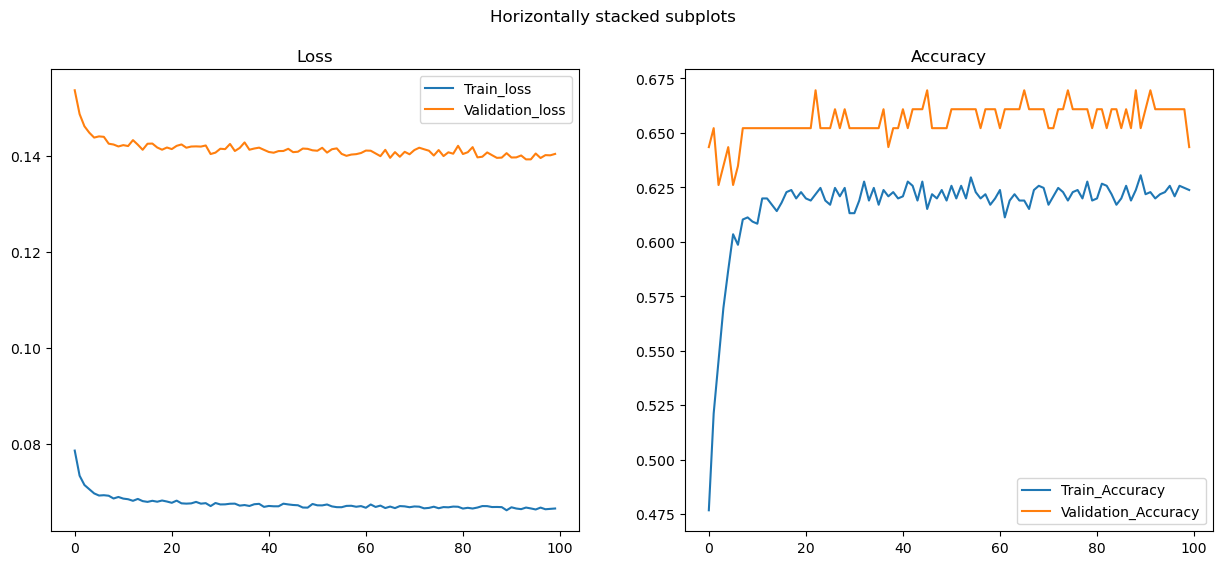

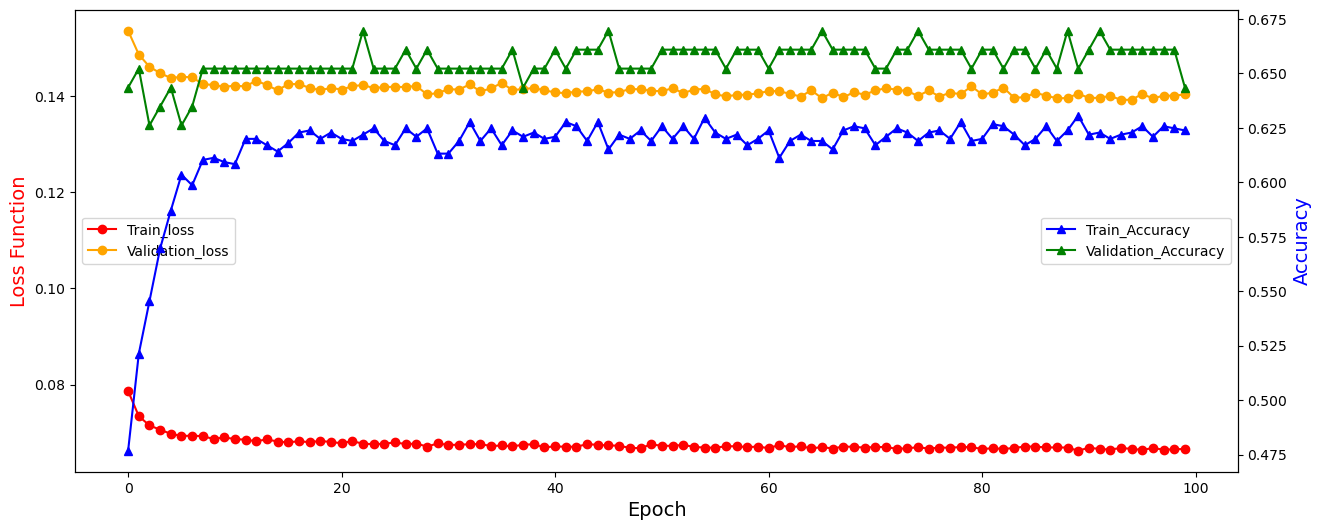

Current time: 19.940 minutes. Time expected till completion: 79.758 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.06691979779726763
Val loss:  0.14038317773653114
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 20.132 minutes. Time expected till completion: 79.532 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06680240985042121
Val loss:  0.140604393378548
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 20.330 minutes. Time expected till completion: 79.325 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 29.37it/s]


train loss:  0.06636344781235523
Val loss:  0.13922787801079128
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 20.526 minutes. Time expected till completion: 79.113 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 28.16it/s]


train loss:  0.06601262496103401
Val loss:  0.13973833167034647
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 20.722 minutes. Time expected till completion: 78.902 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 28.49it/s]


train loss:  0.06635533904429791
Val loss:  0.13920521425164264
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 20.914 minutes. Time expected till completion: 78.677 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.0664635965279961
Val loss:  0.14033126260923304
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 21.110 minutes. Time expected till completion: 78.467 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06668726693500172
Val loss:  0.13992073639579442
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 21.307 minutes. Time expected till completion: 78.259 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06678359224902361
Val loss:  0.13907402909320335
train accuracy:  0.6228239845261122
Val accuracy:  0.6782608695652174
Current time: 21.502 minutes. Time expected till completion: 78.044 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 26.81it/s]


train loss:  0.06645581616193229
Val loss:  0.1397790017335311
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 21.699 minutes. Time expected till completion: 77.838 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06666733794332243
Val loss:  0.13958906038947727
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 21.895 minutes. Time expected till completion: 77.628 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06664049296821802
Val loss:  0.14055192107739656
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 22.090 minutes. Time expected till completion: 77.416 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 26.81it/s]


train loss:  0.06678498707841397
Val loss:  0.13940643590429555
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 22.288 minutes. Time expected till completion: 77.211 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 28.16it/s]


train loss:  0.06664767094691441
Val loss:  0.1403416001278421
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 22.484 minutes. Time expected till completion: 77.001 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06643912501676401
Val loss:  0.1390887825385384
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 22.681 minutes. Time expected till completion: 76.798 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 27.10it/s]


train loss:  0.06649494880172685
Val loss:  0.14000575386959574
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 22.877 minutes. Time expected till completion: 76.587 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06615033636240711
Val loss:  0.13898033629293027
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 23.072 minutes. Time expected till completion: 76.376 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06643849795745466
Val loss:  0.14077919877093772
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 23.271 minutes. Time expected till completion: 76.177 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06679908213578525
Val loss:  0.14002109144044958
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 23.468 minutes. Time expected till completion: 75.972 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 28.49it/s]


train loss:  0.06621471468207915
Val loss:  0.1388951239378556
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 23.666 minutes. Time expected till completion: 75.770 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06650536013064579
Val loss:  0.13849719762802123
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 23.860 minutes. Time expected till completion: 75.556 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06619811778603485
Val loss:  0.13880671210910964
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 24.054 minutes. Time expected till completion: 75.341 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06633087496923525
Val loss:  0.1386864299359529
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 24.250 minutes. Time expected till completion: 75.135 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 27.75it/s]


train loss:  0.06678557845563907
Val loss:  0.1400735792906388
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 24.448 minutes. Time expected till completion: 74.934 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


train loss:  0.06663772129459122
Val loss:  0.1386324758115022
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 24.644 minutes. Time expected till completion: 74.726 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06661483017111655
Val loss:  0.1393852861031242
train accuracy:  0.625725338491296
Val accuracy:  0.6434782608695652
Current time: 24.839 minutes. Time expected till completion: 74.517 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06635249894638356
Val loss:  0.1378742700037749
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 25.034 minutes. Time expected till completion: 74.309 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 27.10it/s]


train loss:  0.0663519789909717
Val loss:  0.13857642204865164
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 25.230 minutes. Time expected till completion: 74.102 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 30.45it/s]


train loss:  0.0660740374020036
Val loss:  0.13895439116851144
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 25.420 minutes. Time expected till completion: 73.876 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06615977914467079
Val loss:  0.13986655888350114
train accuracy:  0.6295938104448743
Val accuracy:  0.6434782608695652
Current time: 25.613 minutes. Time expected till completion: 73.662 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06638651711567227
Val loss:  0.13939691004545793
train accuracy:  0.6179883945841392
Val accuracy:  0.6695652173913044
Current time: 25.805 minutes. Time expected till completion: 73.446 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 27.00it/s]


train loss:  0.06608074246338304
Val loss:  0.13928121691164763
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 26.006 minutes. Time expected till completion: 73.254 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06563721992061032
Val loss:  0.13843412969423377
train accuracy:  0.620889748549323
Val accuracy:  0.6695652173913044
Current time: 26.199 minutes. Time expected till completion: 73.041 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 28.43it/s]


train loss:  0.06615607823809065
Val loss:  0.139147775069527
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 26.392 minutes. Time expected till completion: 72.827 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06656331481048171
Val loss:  0.14001066840213278
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 26.586 minutes. Time expected till completion: 72.616 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 26.39it/s]


train loss:  0.0661079930267666
Val loss:  0.13958228722862576
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 26.786 minutes. Time expected till completion: 72.422 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06641558608187928
Val loss:  0.1389898973962535
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 26.988 minutes. Time expected till completion: 72.233 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06636812193481327
Val loss:  0.13848826937053516
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 27.184 minutes. Time expected till completion: 72.027 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06661190452843155
Val loss:  0.13873668701752373
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 27.379 minutes. Time expected till completion: 71.819 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06614713823311102
Val loss:  0.13884849548339845
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 27.571 minutes. Time expected till completion: 71.606 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06618352283361571
Val loss:  0.13993964869043102
train accuracy:  0.6112185686653772
Val accuracy:  0.6782608695652174
Current time: 27.765 minutes. Time expected till completion: 71.396 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06649639349380361
Val loss:  0.1395431725875191
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 27.958 minutes. Time expected till completion: 71.184 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 25.84it/s]


train loss:  0.06622683869339742
Val loss:  0.13846676867941152
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 28.153 minutes. Time expected till completion: 70.977 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06582686224343468
Val loss:  0.13966102859248286
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 28.349 minutes. Time expected till completion: 70.773 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06615102250755871
Val loss:  0.13962559596351956
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 28.544 minutes. Time expected till completion: 70.567 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06614296844434461
Val loss:  0.13975593369940054
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 28.739 minutes. Time expected till completion: 70.362 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06618383959137494
Val loss:  0.13773852845896845
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 28.930 minutes. Time expected till completion: 70.146 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.06617063698962301
Val loss:  0.13928951543310414
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 29.127 minutes. Time expected till completion: 69.944 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06577537547458302
Val loss:  0.13995584664137467
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 29.322 minutes. Time expected till completion: 69.740 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.06604804672171115
Val loss:  0.1400110363960266
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 29.517 minutes. Time expected till completion: 69.534 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06603687304131528
Val loss:  0.1389368756957676
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 29.711 minutes. Time expected till completion: 69.325 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06605340214716397
Val loss:  0.13854704162348871
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 29.907 minutes. Time expected till completion: 69.122 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06581440619850527
Val loss:  0.13875254081643146
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 30.103 minutes. Time expected till completion: 68.921 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 26.67it/s]


train loss:  0.06591887942135219
Val loss:  0.13818922353827434
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 30.300 minutes. Time expected till completion: 68.720 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.06601987441918836
Val loss:  0.1397652496462283
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 30.493 minutes. Time expected till completion: 68.510 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 27.75it/s]


train loss:  0.0662964973274467
Val loss:  0.1387887047684711
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 30.691 minutes. Time expected till completion: 68.313 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06607744841326597
Val loss:  0.13728640079498292
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 30.887 minutes. Time expected till completion: 68.109 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06615639522642877
Val loss:  0.13799318230670432
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 31.080 minutes. Time expected till completion: 67.900 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


train loss:  0.06547473685192647
Val loss:  0.13840201263842375
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 31.274 minutes. Time expected till completion: 67.695 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06598179131688647
Val loss:  0.1381049000698587
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 31.472 minutes. Time expected till completion: 67.496 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06601756788084077
Val loss:  0.13793468164361042
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 31.668 minutes. Time expected till completion: 67.294 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06589603389485431
Val loss:  0.1384684381277665
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 31.861 minutes. Time expected till completion: 67.087 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06616976090510533
Val loss:  0.13682926478593246
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 32.058 minutes. Time expected till completion: 66.887 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.0657168537435956
Val loss:  0.14066579601039056
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 32.255 minutes. Time expected till completion: 66.687 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 28.48it/s]


train loss:  0.06605811829262591
Val loss:  0.13727479395659073
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 32.450 minutes. Time expected till completion: 66.483 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06610943622008053
Val loss:  0.13714519687320875
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 32.641 minutes. Time expected till completion: 66.272 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 27.45it/s]


train loss:  0.06563051606977009
Val loss:  0.13701182292855305
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 32.840 minutes. Time expected till completion: 66.076 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 28.43it/s]


train loss:  0.06587486588747404
Val loss:  0.13860800732737003
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 33.037 minutes. Time expected till completion: 65.875 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.0660263427336857
Val loss:  0.1389006583586983
train accuracy:  0.6189555125725339
Val accuracy:  0.6782608695652174
Current time: 33.230 minutes. Time expected till completion: 65.669 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06583869814642163
Val loss:  0.13783065598943958
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 33.424 minutes. Time expected till completion: 65.463 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.0656996010235246
Val loss:  0.13778561405513598
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 33.620 minutes. Time expected till completion: 65.262 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06605019877219799
Val loss:  0.13812522888183593
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 33.812 minutes. Time expected till completion: 65.054 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06546098345483525
Val loss:  0.1376940597658572
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 34.005 minutes. Time expected till completion: 64.847 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06589658342200967
Val loss:  0.1364110309144725
train accuracy:  0.6228239845261122
Val accuracy:  0.6782608695652174
Current time: 34.200 minutes. Time expected till completion: 64.645 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06550101379591906
Val loss:  0.1376731110655743
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 34.396 minutes. Time expected till completion: 64.443 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06585762607982126
Val loss:  0.14034038833949877
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 34.589 minutes. Time expected till completion: 64.236 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 26.95it/s]


train loss:  0.06562164051159207
Val loss:  0.13945582327635392
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 34.783 minutes. Time expected till completion: 64.032 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06624419188822261
Val loss:  0.13757489142210588
train accuracy:  0.6228239845261122
Val accuracy:  0.6782608695652174
Current time: 34.977 minutes. Time expected till completion: 63.828 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06555057990020663
Val loss:  0.13608533610468326
train accuracy:  0.6286266924564797
Val accuracy:  0.6782608695652174
Current time: 35.169 minutes. Time expected till completion: 63.621 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 26.57it/s]


train loss:  0.06575324987304511
Val loss:  0.13827856519947881
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 35.365 minutes. Time expected till completion: 63.419 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.06543905834164794
Val loss:  0.14049306848774787
train accuracy:  0.6276595744680851
Val accuracy:  0.6434782608695652
Current time: 35.558 minutes. Time expected till completion: 63.214 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06551096650341262
Val loss:  0.13835533961005833
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 35.755 minutes. Time expected till completion: 63.016 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06537024800735931
Val loss:  0.13997185385745506
train accuracy:  0.625725338491296
Val accuracy:  0.6434782608695652
Current time: 35.956 minutes. Time expected till completion: 62.824 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06555648796562992
Val loss:  0.13896140430284584
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 36.151 minutes. Time expected till completion: 62.622 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06550508259112876
Val loss:  0.13676592578058658
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 36.349 minutes. Time expected till completion: 62.425 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06524423300874072
Val loss:  0.1376391193141108
train accuracy:  0.632495164410058
Val accuracy:  0.6695652173913044
Current time: 36.543 minutes. Time expected till completion: 62.222 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.0654576700937356
Val loss:  0.1375624936559926
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 36.741 minutes. Time expected till completion: 62.025 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06581705998867116
Val loss:  0.13683562226917434
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 36.931 minutes. Time expected till completion: 61.815 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06572887295680535
Val loss:  0.13928557427033134
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 37.128 minutes. Time expected till completion: 61.617 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06538154055117638
Val loss:  0.13693434103675511
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 37.324 minutes. Time expected till completion: 61.416 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.0656378236338064
Val loss:  0.13799069860707158
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 37.520 minutes. Time expected till completion: 61.216 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.06600867168585152
Val loss:  0.137239452548649
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 37.713 minutes. Time expected till completion: 61.013 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06549668571474013
Val loss:  0.13732052834137626
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 37.908 minutes. Time expected till completion: 60.811 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 28.06it/s]


train loss:  0.06577246487717103
Val loss:  0.14015260105547697
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 38.105 minutes. Time expected till completion: 60.613 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 26.81it/s]


train loss:  0.06548654986995793
Val loss:  0.136124354860057
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 38.304 minutes. Time expected till completion: 60.417 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06583401289853183
Val loss:  0.13606713025466255
train accuracy:  0.6228239845261122
Val accuracy:  0.6782608695652174
Current time: 38.497 minutes. Time expected till completion: 60.213 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.06554142366986672
Val loss:  0.1369672681974328
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 38.693 minutes. Time expected till completion: 60.014 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06576590871211407
Val loss:  0.13472806318946506
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 38.888 minutes. Time expected till completion: 59.813 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06574800898765919
Val loss:  0.13510068188542906
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 39.082 minutes. Time expected till completion: 59.610 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06539617458671851
Val loss:  0.13585956874101057
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 39.275 minutes. Time expected till completion: 59.405 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06560268369818564
Val loss:  0.13708567204682723
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Saving model checkpoint


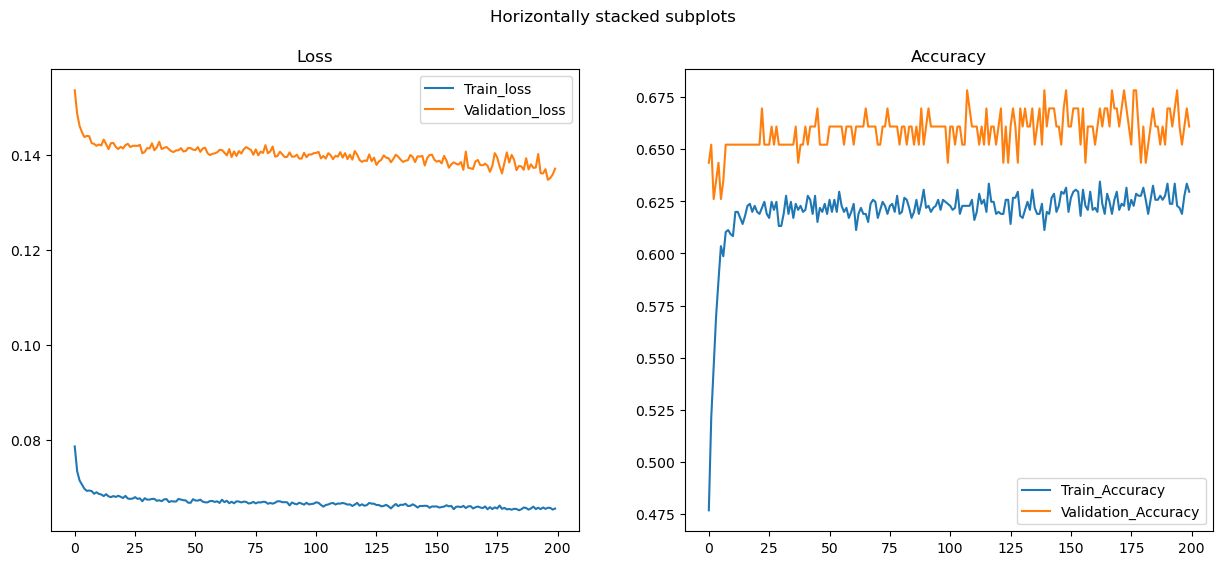

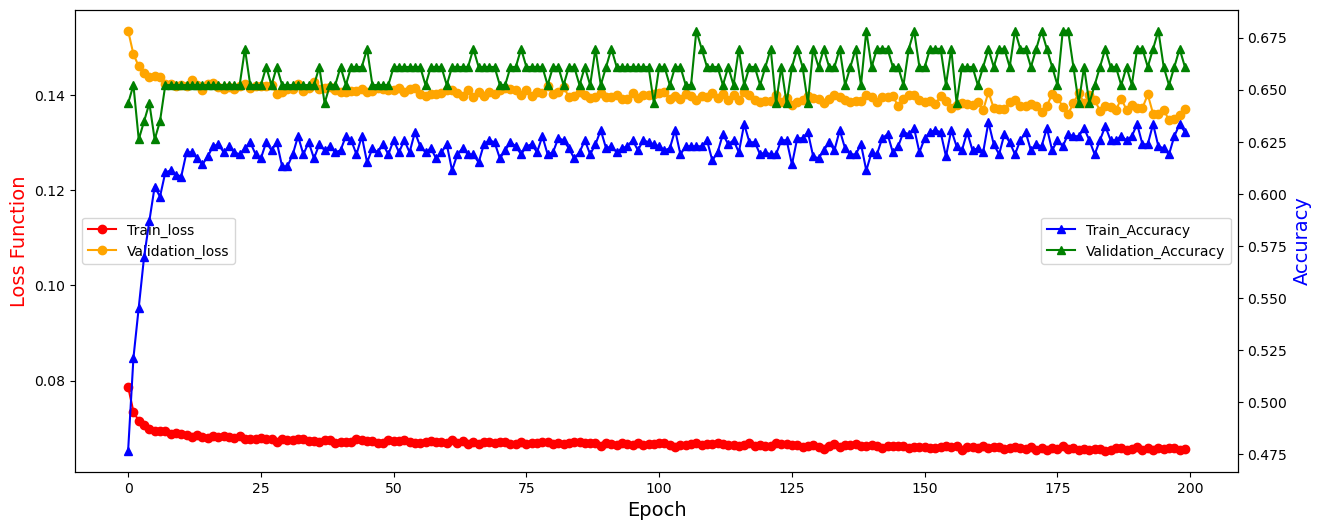

Current time: 39.484 minutes. Time expected till completion: 59.226 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06530036542355669
Val loss:  0.13612732731777688
train accuracy:  0.6276595744680851
Val accuracy:  0.6695652173913044
Current time: 39.682 minutes. Time expected till completion: 59.029 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06568743435511044
Val loss:  0.1359253344328507
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 39.876 minutes. Time expected till completion: 58.826 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06589344455149003
Val loss:  0.13755299734032672
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 40.070 minutes. Time expected till completion: 58.625 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 28.48it/s]


train loss:  0.06539439935979345
Val loss:  0.1359155898508818
train accuracy:  0.6276595744680851
Val accuracy:  0.6695652173913044
Current time: 40.266 minutes. Time expected till completion: 58.424 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


train loss:  0.06502573488989928
Val loss:  0.1377536400504734
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 40.463 minutes. Time expected till completion: 58.227 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06560563055412913
Val loss:  0.13795910555383434
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 40.657 minutes. Time expected till completion: 58.025 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 27.35it/s]


train loss:  0.06526848362538985
Val loss:  0.13841331730718198
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 40.853 minutes. Time expected till completion: 57.826 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06560274722267166
Val loss:  0.13766305446624755
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 41.050 minutes. Time expected till completion: 57.628 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.06548889808544107
Val loss:  0.13626482020253722
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 41.248 minutes. Time expected till completion: 57.432 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 29.49it/s]


train loss:  0.06515971177781804
Val loss:  0.13769515079000721
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 41.439 minutes. Time expected till completion: 57.226 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06520656731188643
Val loss:  0.13920002035472703
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 41.635 minutes. Time expected till completion: 57.026 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.0656810764879046
Val loss:  0.13612618653670602
train accuracy:  0.6276595744680851
Val accuracy:  0.6695652173913044
Current time: 41.832 minutes. Time expected till completion: 56.828 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 26.29it/s]


train loss:  0.06535347811949783
Val loss:  0.1347413876782293
train accuracy:  0.6266924564796905
Val accuracy:  0.6782608695652174
Current time: 42.027 minutes. Time expected till completion: 56.629 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


train loss:  0.06525374686694929
Val loss:  0.1363059603649637
train accuracy:  0.6363636363636364
Val accuracy:  0.6695652173913044
Current time: 42.220 minutes. Time expected till completion: 56.424 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06524433688453364
Val loss:  0.13616013319596001
train accuracy:  0.6237911025145068
Val accuracy:  0.6782608695652174
Current time: 42.415 minutes. Time expected till completion: 56.224 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06513558959361432
Val loss:  0.13907448312510615
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 42.610 minutes. Time expected till completion: 56.025 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06485674442359511
Val loss:  0.13585124378618987
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 42.805 minutes. Time expected till completion: 55.824 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06515254227289609
Val loss:  0.1360901635626088
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 42.999 minutes. Time expected till completion: 55.622 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06528318401000947
Val loss:  0.13717751243840093
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 43.195 minutes. Time expected till completion: 55.423 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 28.17it/s]


train loss:  0.06516237680870514
Val loss:  0.1350822785626287
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 43.392 minutes. Time expected till completion: 55.226 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06490925559683972
Val loss:  0.13646042761595353
train accuracy:  0.6334622823984526
Val accuracy:  0.6608695652173913
Current time: 43.585 minutes. Time expected till completion: 55.023 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06525250364318345
Val loss:  0.13965407350788947
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 43.783 minutes. Time expected till completion: 54.828 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06554754179266481
Val loss:  0.14066593128701915
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 43.983 minutes. Time expected till completion: 54.634 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06533167446374433
Val loss:  0.13932985326518182
train accuracy:  0.6334622823984526
Val accuracy:  0.6608695652173913
Current time: 44.180 minutes. Time expected till completion: 54.437 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06519484496900606
Val loss:  0.1370243435320647
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 44.374 minutes. Time expected till completion: 54.235 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06523016619728428
Val loss:  0.13657052879748138
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 44.573 minutes. Time expected till completion: 54.039 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06545331791706197
Val loss:  0.1358590675436932
train accuracy:  0.6363636363636364
Val accuracy:  0.6869565217391305
Current time: 44.768 minutes. Time expected till completion: 53.839 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 28.06it/s]


train loss:  0.0652924908660136
Val loss:  0.13775624866070954
train accuracy:  0.6382978723404256
Val accuracy:  0.6782608695652174
Current time: 44.962 minutes. Time expected till completion: 53.639 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06504404786938164
Val loss:  0.13674461841583252
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 45.156 minutes. Time expected till completion: 53.438 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 29.72it/s]


train loss:  0.06517128597375733
Val loss:  0.13685084892355878
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 45.353 minutes. Time expected till completion: 53.241 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.0648125261933015
Val loss:  0.13685482481251593
train accuracy:  0.6276595744680851
Val accuracy:  0.6782608695652174
Current time: 45.550 minutes. Time expected till completion: 53.043 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06460717660546073
Val loss:  0.136106392611628
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 45.743 minutes. Time expected till completion: 52.840 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 28.17it/s]


train loss:  0.06504527691254533
Val loss:  0.13522635905638986
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 45.938 minutes. Time expected till completion: 52.642 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06484893143061743
Val loss:  0.13548980173857317
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 46.136 minutes. Time expected till completion: 52.445 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06495939030868633
Val loss:  0.13792545277139415
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 46.332 minutes. Time expected till completion: 52.247 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06533654596173787
Val loss:  0.13595590591430665
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 46.526 minutes. Time expected till completion: 52.046 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06471996190930704
Val loss:  0.13591910963473114
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 46.724 minutes. Time expected till completion: 51.850 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06505771756633338
Val loss:  0.13426752038623976
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 46.919 minutes. Time expected till completion: 51.650 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.0646912286659735
Val loss:  0.13512271176213803
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 47.114 minutes. Time expected till completion: 51.451 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:00<00:00, 28.48it/s]


train loss:  0.06529023130811622
Val loss:  0.13731370075889257
train accuracy:  0.6286266924564797
Val accuracy:  0.6782608695652174
Current time: 47.305 minutes. Time expected till completion: 51.247 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06519798925812978
Val loss:  0.13608056203178737
train accuracy:  0.6266924564796905
Val accuracy:  0.6782608695652174
Current time: 47.504 minutes. Time expected till completion: 51.052 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06488230282610113
Val loss:  0.13414834530457206
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 47.703 minutes. Time expected till completion: 50.857 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06490850852121467
Val loss:  0.13484356507011083
train accuracy:  0.625725338491296
Val accuracy:  0.6782608695652174
Current time: 47.894 minutes. Time expected till completion: 50.653 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06479061439604547
Val loss:  0.13533574031746906
train accuracy:  0.6247582205029013
Val accuracy:  0.6782608695652174
Current time: 48.085 minutes. Time expected till completion: 50.450 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06509061333519808
Val loss:  0.13514988007752793
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 48.280 minutes. Time expected till completion: 50.251 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 28.43it/s]


train loss:  0.06473424137215089
Val loss:  0.13528538942337037
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 48.477 minutes. Time expected till completion: 50.053 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 25.67it/s]


train loss:  0.06486581107403369
Val loss:  0.13812246478122214
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 48.673 minutes. Time expected till completion: 49.856 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06502822652545612
Val loss:  0.13547549558722455
train accuracy:  0.6305609284332688
Val accuracy:  0.6782608695652174
Current time: 48.865 minutes. Time expected till completion: 49.653 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06468425474960061
Val loss:  0.13632272585578586
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 49.061 minutes. Time expected till completion: 49.455 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 30.14it/s]


train loss:  0.06484805384733691
Val loss:  0.1356787277304608
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 49.255 minutes. Time expected till completion: 49.255 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 27.35it/s]


train loss:  0.06500385105033446
Val loss:  0.13752969918043717
train accuracy:  0.6305609284332688
Val accuracy:  0.6782608695652174
Current time: 49.447 minutes. Time expected till completion: 49.053 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06485387521509506
Val loss:  0.13663975466852601
train accuracy:  0.6247582205029013
Val accuracy:  0.6434782608695652
Current time: 49.644 minutes. Time expected till completion: 48.856 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06470256749850407
Val loss:  0.13715395357297813
train accuracy:  0.625725338491296
Val accuracy:  0.6782608695652174
Current time: 49.837 minutes. Time expected till completion: 48.655 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06505317164574186
Val loss:  0.13570616763571033
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 50.034 minutes. Time expected till completion: 48.458 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 29.55it/s]


train loss:  0.06529749880906922
Val loss:  0.137639233858689
train accuracy:  0.6441005802707931
Val accuracy:  0.6782608695652174
Current time: 50.225 minutes. Time expected till completion: 48.256 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06498590722766559
Val loss:  0.13503478091696033
train accuracy:  0.6315280464216635
Val accuracy:  0.6869565217391305
Current time: 50.421 minutes. Time expected till completion: 48.058 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06420037715301292
Val loss:  0.1367841793143231
train accuracy:  0.6402321083172147
Val accuracy:  0.6782608695652174
Current time: 50.615 minutes. Time expected till completion: 47.858 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 26.25it/s]


train loss:  0.06502767267494644
Val loss:  0.13512702765672102
train accuracy:  0.6218568665377177
Val accuracy:  0.6869565217391305
Current time: 50.817 minutes. Time expected till completion: 47.666 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06485670937560283
Val loss:  0.1346670803816422
train accuracy:  0.6334622823984526
Val accuracy:  0.6869565217391305
Current time: 51.009 minutes. Time expected till completion: 47.464 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06483618197404209
Val loss:  0.13641343635061512
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 51.206 minutes. Time expected till completion: 47.267 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 27.75it/s]


train loss:  0.06471770696298758
Val loss:  0.13623596377994704
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 51.404 minutes. Time expected till completion: 47.071 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 26.57it/s]


train loss:  0.06467476815734656
Val loss:  0.1372676185939623
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 51.598 minutes. Time expected till completion: 46.871 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06495154682164958
Val loss:  0.13587777614593505
train accuracy:  0.6276595744680851
Val accuracy:  0.6782608695652174
Current time: 51.791 minutes. Time expected till completion: 46.671 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 26.81it/s]


train loss:  0.06434690398911673
Val loss:  0.13684424887532773
train accuracy:  0.6363636363636364
Val accuracy:  0.6695652173913044
Current time: 51.990 minutes. Time expected till completion: 46.476 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06446945661502373
Val loss:  0.13566413547681724
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 52.188 minutes. Time expected till completion: 46.280 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.0645471497130809
Val loss:  0.13840325915295146
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 52.381 minutes. Time expected till completion: 46.079 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06460955323979288
Val loss:  0.13591116044832313
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 52.576 minutes. Time expected till completion: 45.881 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06452505103162917
Val loss:  0.13513767356457917
train accuracy:  0.6344294003868471
Val accuracy:  0.6782608695652174
Current time: 52.771 minutes. Time expected till completion: 45.682 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:00<00:00, 28.92it/s]


train loss:  0.06449106485516236
Val loss:  0.13634160186933433
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 52.974 minutes. Time expected till completion: 45.491 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:00<00:00, 27.30it/s]


train loss:  0.06434791490464423
Val loss:  0.1369357337122378
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 53.167 minutes. Time expected till completion: 45.291 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06496780649605756
Val loss:  0.1355924295342487
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 53.371 minutes. Time expected till completion: 45.099 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:00<00:00, 27.35it/s]


train loss:  0.06487812629290199
Val loss:  0.13434651571771372
train accuracy:  0.6276595744680851
Val accuracy:  0.6869565217391305
Current time: 53.567 minutes. Time expected till completion: 44.901 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 27.85it/s]


train loss:  0.06469845656500102
Val loss:  0.13794273708177648
train accuracy:  0.6276595744680851
Val accuracy:  0.6782608695652174
Current time: 53.761 minutes. Time expected till completion: 44.703 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06481759005173954
Val loss:  0.1345650393029918
train accuracy:  0.6344294003868471
Val accuracy:  0.6782608695652174
Current time: 53.954 minutes. Time expected till completion: 44.502 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.06459751315919297
Val loss:  0.1390961729961893
train accuracy:  0.6411992263056093
Val accuracy:  0.6608695652173913
Current time: 54.150 minutes. Time expected till completion: 44.305 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06466722367349399
Val loss:  0.13909609887910926
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 54.348 minutes. Time expected till completion: 44.108 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


train loss:  0.06452174966063214
Val loss:  0.13404421443524567
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 54.542 minutes. Time expected till completion: 43.909 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


train loss:  0.06432045601322757
Val loss:  0.13704047669535097
train accuracy:  0.6382978723404256
Val accuracy:  0.6608695652173913
Current time: 54.736 minutes. Time expected till completion: 43.710 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06461486249182165
Val loss:  0.13699950860894244
train accuracy:  0.6353965183752418
Val accuracy:  0.6521739130434783
Current time: 54.932 minutes. Time expected till completion: 43.512 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06455451803465646
Val loss:  0.13412049127661663
train accuracy:  0.632495164410058
Val accuracy:  0.6782608695652174
Current time: 55.127 minutes. Time expected till completion: 43.314 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06473200147110443
Val loss:  0.1370332526124042
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 55.321 minutes. Time expected till completion: 43.115 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.0646286202699119
Val loss:  0.1342342874278193
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 55.515 minutes. Time expected till completion: 42.916 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 29.38it/s]


train loss:  0.06471209213627607
Val loss:  0.13628922234410826
train accuracy:  0.6305609284332688
Val accuracy:  0.6869565217391305
Current time: 55.711 minutes. Time expected till completion: 42.719 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06471292579427679
Val loss:  0.13537717953972195
train accuracy:  0.6305609284332688
Val accuracy:  0.6782608695652174
Current time: 55.908 minutes. Time expected till completion: 42.521 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06427773458584134
Val loss:  0.13562261488126673
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 56.106 minutes. Time expected till completion: 42.326 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06432343463141406
Val loss:  0.1352599693381268
train accuracy:  0.6334622823984526
Val accuracy:  0.6869565217391305
Current time: 56.305 minutes. Time expected till completion: 42.131 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06444147609649821
Val loss:  0.13510385077932607
train accuracy:  0.6247582205029013
Val accuracy:  0.6869565217391305
Current time: 56.499 minutes. Time expected till completion: 41.931 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 27.45it/s]


train loss:  0.06477488874236205
Val loss:  0.13354394746863324
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 56.692 minutes. Time expected till completion: 41.732 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06428822459980875
Val loss:  0.13585254886875983
train accuracy:  0.6431334622823984
Val accuracy:  0.6782608695652174
Current time: 56.882 minutes. Time expected till completion: 41.530 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:00<00:00, 27.75it/s]


train loss:  0.06437022404698385
Val loss:  0.13465755400450333
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 57.076 minutes. Time expected till completion: 41.331 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 27.85it/s]


train loss:  0.06420251600285794
Val loss:  0.1342597282451132
train accuracy:  0.6334622823984526
Val accuracy:  0.6869565217391305
Current time: 57.271 minutes. Time expected till completion: 41.132 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 25.93it/s]


train loss:  0.06444361984614477
Val loss:  0.13483643168988435
train accuracy:  0.6421663442940039
Val accuracy:  0.6695652173913044
Current time: 57.462 minutes. Time expected till completion: 40.932 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06406547483669259
Val loss:  0.13613863820615021
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 57.659 minutes. Time expected till completion: 40.735 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06387568990082068
Val loss:  0.13569531285244485
train accuracy:  0.6460348162475822
Val accuracy:  0.6782608695652174
Current time: 57.858 minutes. Time expected till completion: 40.540 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 29.66it/s]


train loss:  0.06458455439462422
Val loss:  0.13319868471311486
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 58.052 minutes. Time expected till completion: 40.342 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06444518397808997
Val loss:  0.13694246126257856
train accuracy:  0.6382978723404256
Val accuracy:  0.6782608695652174
Current time: 58.246 minutes. Time expected till completion: 40.142 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:00<00:00, 29.20it/s]


train loss:  0.06417757457183454
Val loss:  0.13798769764278246
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 58.441 minutes. Time expected till completion: 39.944 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.06472841977381383
Val loss:  0.13525839784870977
train accuracy:  0.6344294003868471
Val accuracy:  0.6869565217391305
Current time: 58.636 minutes. Time expected till completion: 39.746 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06431037003113177
Val loss:  0.13766131193741507
train accuracy:  0.6441005802707931
Val accuracy:  0.6608695652173913
Current time: 58.832 minutes. Time expected till completion: 39.549 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


train loss:  0.06473084258157004
Val loss:  0.13457770969556726
train accuracy:  0.6286266924564797
Val accuracy:  0.6782608695652174
Saving model checkpoint


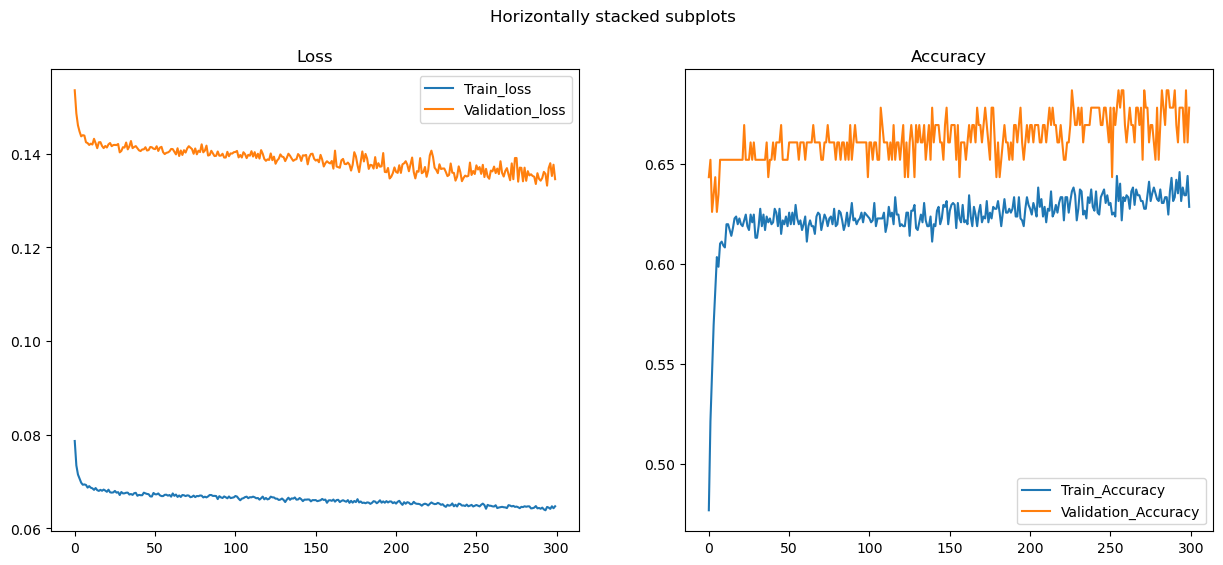

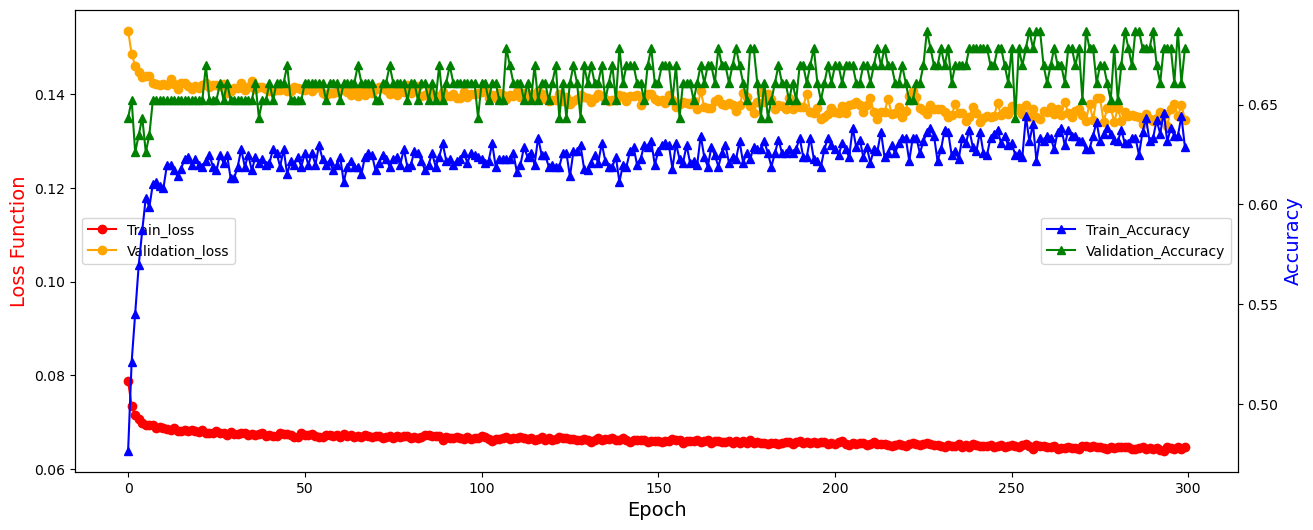

Current time: 59.040 minutes. Time expected till completion: 39.360 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:00<00:00, 29.96it/s]


train loss:  0.06442525562050264
Val loss:  0.13411942668583082
train accuracy:  0.632495164410058
Val accuracy:  0.6782608695652174
Current time: 59.238 minutes. Time expected till completion: 39.164 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06452672659082616
Val loss:  0.13637427817220274
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 59.440 minutes. Time expected till completion: 38.970 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06456725486703721
Val loss:  0.13448532197786414
train accuracy:  0.6402321083172147
Val accuracy:  0.6782608695652174
Current time: 59.631 minutes. Time expected till completion: 38.770 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 29.61it/s]


train loss:  0.06424316066376706
Val loss:  0.13763682116632875
train accuracy:  0.6411992263056093
Val accuracy:  0.6782608695652174
Current time: 59.825 minutes. Time expected till completion: 38.572 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06470838431232903
Val loss:  0.13466296351474263
train accuracy:  0.6295938104448743
Val accuracy:  0.6869565217391305
Current time: 60.022 minutes. Time expected till completion: 38.375 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06494376374628373
Val loss:  0.13542219089425128
train accuracy:  0.6353965183752418
Val accuracy:  0.6869565217391305
Current time: 60.220 minutes. Time expected till completion: 38.179 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 27.05it/s]


train loss:  0.0646380736011601
Val loss:  0.1349137430605681
train accuracy:  0.625725338491296
Val accuracy:  0.6782608695652174
Current time: 60.415 minutes. Time expected till completion: 37.981 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06436389033291741
Val loss:  0.13552088478337163
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 60.612 minutes. Time expected till completion: 37.784 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 27.45it/s]


train loss:  0.06449196399756972
Val loss:  0.1368958514669667
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 60.809 minutes. Time expected till completion: 37.587 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 30.38it/s]


train loss:  0.06430752837680986
Val loss:  0.13518274607865707
train accuracy:  0.6334622823984526
Val accuracy:  0.6956521739130435
Current time: 61.006 minutes. Time expected till completion: 37.391 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 26.48it/s]


train loss:  0.06436592893858713
Val loss:  0.13542809693709665
train accuracy:  0.6441005802707931
Val accuracy:  0.6782608695652174
Current time: 61.200 minutes. Time expected till completion: 37.192 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 29.32it/s]


train loss:  0.06413391676354915
Val loss:  0.13491025696630063
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 61.395 minutes. Time expected till completion: 36.995 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.06418120705412711
Val loss:  0.1376762260561404
train accuracy:  0.6450676982591876
Val accuracy:  0.6869565217391305
Current time: 61.593 minutes. Time expected till completion: 36.798 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.0648286002516977
Val loss:  0.13815754185552181
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 61.794 minutes. Time expected till completion: 36.604 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 27.10it/s]


train loss:  0.0640744427417187
Val loss:  0.13578255383864693
train accuracy:  0.6392649903288201
Val accuracy:  0.6695652173913044
Current time: 61.989 minutes. Time expected till completion: 36.406 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06447998265694373
Val loss:  0.13749726181444916
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 62.188 minutes. Time expected till completion: 36.211 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.06406657141228017
Val loss:  0.1359641873318216
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 62.384 minutes. Time expected till completion: 36.014 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 27.10it/s]


train loss:  0.06398435026349597
Val loss:  0.1350865312244581
train accuracy:  0.6392649903288201
Val accuracy:  0.6956521739130435
Current time: 62.581 minutes. Time expected till completion: 35.817 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06459424147522888
Val loss:  0.13450608823610388
train accuracy:  0.6421663442940039
Val accuracy:  0.6956521739130435
Current time: 62.775 minutes. Time expected till completion: 35.619 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.06392122565892956
Val loss:  0.13593893673108973
train accuracy:  0.6411992263056093
Val accuracy:  0.6608695652173913
Current time: 62.977 minutes. Time expected till completion: 35.425 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 27.75it/s]


train loss:  0.06429130686320926
Val loss:  0.13588967426963475
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 63.175 minutes. Time expected till completion: 35.229 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 26.57it/s]


train loss:  0.06431638387462388
Val loss:  0.1355708790862042
train accuracy:  0.6402321083172147
Val accuracy:  0.6869565217391305
Current time: 63.371 minutes. Time expected till completion: 35.031 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


train loss:  0.06447431802519055
Val loss:  0.13462262827417124
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 63.564 minutes. Time expected till completion: 34.832 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 27.75it/s]


train loss:  0.06407145662971807
Val loss:  0.13552957928698997
train accuracy:  0.6421663442940039
Val accuracy:  0.6869565217391305
Current time: 63.759 minutes. Time expected till completion: 34.634 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.0640827330906571
Val loss:  0.13474770628887675
train accuracy:  0.6392649903288201
Val accuracy:  0.6782608695652174
Current time: 63.953 minutes. Time expected till completion: 34.436 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 28.06it/s]


train loss:  0.06423587339067367
Val loss:  0.13581883751827736
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 64.147 minutes. Time expected till completion: 34.238 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06460510652577162
Val loss:  0.13633820129477459
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 64.343 minutes. Time expected till completion: 34.041 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.064334943285302
Val loss:  0.13590861247933428
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 64.537 minutes. Time expected till completion: 33.843 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 28.06it/s]


train loss:  0.06415167099272029
Val loss:  0.1348387132520261
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 64.732 minutes. Time expected till completion: 33.645 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 26.91it/s]


train loss:  0.0642180716046051
Val loss:  0.13821655978327213
train accuracy:  0.6392649903288201
Val accuracy:  0.6608695652173913
Current time: 64.925 minutes. Time expected till completion: 33.446 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


train loss:  0.0643216407852431
Val loss:  0.13526654295299365
train accuracy:  0.6392649903288201
Val accuracy:  0.6782608695652174
Current time: 65.123 minutes. Time expected till completion: 33.250 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06387761650279135
Val loss:  0.13689111419346023
train accuracy:  0.6411992263056093
Val accuracy:  0.6608695652173913
Current time: 65.319 minutes. Time expected till completion: 33.053 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 28.17it/s]


train loss:  0.06412124858603487
Val loss:  0.13741728015567944
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 65.516 minutes. Time expected till completion: 32.857 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 28.59it/s]


train loss:  0.06415790809422904
Val loss:  0.13529142659643423
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 65.709 minutes. Time expected till completion: 32.658 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 27.45it/s]


train loss:  0.06403211750652159
Val loss:  0.13473848415457684
train accuracy:  0.6353965183752418
Val accuracy:  0.6869565217391305
Current time: 65.907 minutes. Time expected till completion: 32.462 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06361143755036582
Val loss:  0.13559177751126497
train accuracy:  0.6421663442940039
Val accuracy:  0.6956521739130435
Current time: 66.103 minutes. Time expected till completion: 32.264 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06381030527719907
Val loss:  0.13650722296341605
train accuracy:  0.6411992263056093
Val accuracy:  0.6695652173913044
Current time: 66.303 minutes. Time expected till completion: 32.070 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06393610958435088
Val loss:  0.13722227397172349
train accuracy:  0.6411992263056093
Val accuracy:  0.6869565217391305
Current time: 66.495 minutes. Time expected till completion: 31.871 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 27.45it/s]


train loss:  0.06373853419458843
Val loss:  0.13511036167974058
train accuracy:  0.6295938104448743
Val accuracy:  0.6782608695652174
Current time: 66.693 minutes. Time expected till completion: 31.674 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06384252625692283
Val loss:  0.13653902489206066
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 66.888 minutes. Time expected till completion: 31.477 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06389379656983529
Val loss:  0.13404830538708232
train accuracy:  0.6353965183752418
Val accuracy:  0.6869565217391305
Current time: 67.084 minutes. Time expected till completion: 31.279 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06397919740160384
Val loss:  0.1368467444958894
train accuracy:  0.6392649903288201
Val accuracy:  0.6869565217391305
Current time: 67.289 minutes. Time expected till completion: 31.087 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.06405269488605816
Val loss:  0.13608734504036282
train accuracy:  0.6431334622823984
Val accuracy:  0.6782608695652174
Current time: 67.488 minutes. Time expected till completion: 30.891 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06454919702310397
Val loss:  0.13700824405836023
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 67.684 minutes. Time expected till completion: 30.694 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 27.05it/s]


train loss:  0.0637527232705048
Val loss:  0.13439206869705864
train accuracy:  0.6286266924564797
Val accuracy:  0.6782608695652174
Current time: 67.880 minutes. Time expected till completion: 30.497 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 26.71it/s]


train loss:  0.06388489149755851
Val loss:  0.13484533455060876
train accuracy:  0.632495164410058
Val accuracy:  0.6869565217391305
Current time: 68.074 minutes. Time expected till completion: 30.299 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 28.16it/s]


train loss:  0.06362596690308886
Val loss:  0.13589828947316046
train accuracy:  0.6450676982591876
Val accuracy:  0.6782608695652174
Current time: 68.272 minutes. Time expected till completion: 30.103 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06369870589826278
Val loss:  0.1354302924612294
train accuracy:  0.6373307543520309
Val accuracy:  0.6869565217391305
Current time: 68.476 minutes. Time expected till completion: 29.909 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 26.57it/s]


train loss:  0.06407362124675478
Val loss:  0.1350215714910756
train accuracy:  0.6363636363636364
Val accuracy:  0.6695652173913044
Current time: 68.673 minutes. Time expected till completion: 29.712 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 28.48it/s]


train loss:  0.06382584421962097
Val loss:  0.13530465105305547
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 68.873 minutes. Time expected till completion: 29.517 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 27.85it/s]


train loss:  0.06389019642623296
Val loss:  0.1364057939985524
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 69.069 minutes. Time expected till completion: 29.320 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:00<00:00, 28.98it/s]


train loss:  0.0637174297693389
Val loss:  0.13780641400295754
train accuracy:  0.6392649903288201
Val accuracy:  0.6782608695652174
Current time: 69.270 minutes. Time expected till completion: 29.125 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:00<00:00, 26.48it/s]


train loss:  0.06372455206323177
Val loss:  0.13661480053611424
train accuracy:  0.6431334622823984
Val accuracy:  0.6695652173913044
Current time: 69.469 minutes. Time expected till completion: 28.929 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06353939859272202
Val loss:  0.13493847069532974
train accuracy:  0.6479690522243714
Val accuracy:  0.6956521739130435
Current time: 69.665 minutes. Time expected till completion: 28.732 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


train loss:  0.06439546119544215
Val loss:  0.13538677122281945
train accuracy:  0.632495164410058
Val accuracy:  0.6869565217391305
Current time: 69.866 minutes. Time expected till completion: 28.537 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


train loss:  0.06352397424801175
Val loss:  0.1351594546566839
train accuracy:  0.6450676982591876
Val accuracy:  0.6956521739130435
Current time: 70.066 minutes. Time expected till completion: 28.341 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 26.62it/s]


train loss:  0.06423656368624542
Val loss:  0.13711984313052633
train accuracy:  0.6305609284332688
Val accuracy:  0.6956521739130435
Current time: 70.264 minutes. Time expected till completion: 28.145 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06360967195010969
Val loss:  0.13401316611663155
train accuracy:  0.6450676982591876
Val accuracy:  0.6869565217391305
Current time: 70.458 minutes. Time expected till completion: 27.947 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06384445551055082
Val loss:  0.1354313788206681
train accuracy:  0.6402321083172147
Val accuracy:  0.6956521739130435
Current time: 70.656 minutes. Time expected till completion: 27.751 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.0639452877773307
Val loss:  0.13437536488408627
train accuracy:  0.6295938104448743
Val accuracy:  0.6782608695652174
Current time: 70.852 minutes. Time expected till completion: 27.554 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 26.48it/s]


train loss:  0.06422097580345272
Val loss:  0.1341384892878325
train accuracy:  0.6441005802707931
Val accuracy:  0.6782608695652174
Current time: 71.046 minutes. Time expected till completion: 27.356 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06426652239876975
Val loss:  0.1371429002803305
train accuracy:  0.6499032882011605
Val accuracy:  0.6608695652173913
Current time: 71.243 minutes. Time expected till completion: 27.159 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06430261041716866
Val loss:  0.1362062744472338
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 71.440 minutes. Time expected till completion: 26.962 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 29.26it/s]


train loss:  0.06350545392045662
Val loss:  0.13352330404779186
train accuracy:  0.6450676982591876
Val accuracy:  0.6782608695652174
Current time: 71.636 minutes. Time expected till completion: 26.765 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 29.43it/s]


train loss:  0.06378257020990899
Val loss:  0.1372452621874602
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 71.829 minutes. Time expected till completion: 26.567 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06383545399865052
Val loss:  0.13829034566879272
train accuracy:  0.6441005802707931
Val accuracy:  0.6782608695652174
Current time: 72.029 minutes. Time expected till completion: 26.371 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.06356975372801436
Val loss:  0.13652923469958098
train accuracy:  0.6508704061895552
Val accuracy:  0.6782608695652174
Current time: 72.228 minutes. Time expected till completion: 26.175 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06391095942178132
Val loss:  0.13552817728208458
train accuracy:  0.6266924564796905
Val accuracy:  0.6869565217391305
Current time: 72.423 minutes. Time expected till completion: 25.978 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


train loss:  0.06389692275851562
Val loss:  0.1363812612450641
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 72.618 minutes. Time expected till completion: 25.780 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 28.48it/s]


train loss:  0.06381889324584829
Val loss:  0.13619431101757548
train accuracy:  0.6421663442940039
Val accuracy:  0.6869565217391305
Current time: 72.812 minutes. Time expected till completion: 25.583 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.0638689262724015
Val loss:  0.13766869151073954
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 73.008 minutes. Time expected till completion: 25.386 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:00<00:00, 27.00it/s]


train loss:  0.0641476408771205
Val loss:  0.13568155039911683
train accuracy:  0.6411992263056093
Val accuracy:  0.6869565217391305
Current time: 73.204 minutes. Time expected till completion: 25.189 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06403979814721261
Val loss:  0.1349822884020598
train accuracy:  0.632495164410058
Val accuracy:  0.6869565217391305
Current time: 73.404 minutes. Time expected till completion: 24.993 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 28.43it/s]


train loss:  0.06355137906867715
Val loss:  0.13503252267837523
train accuracy:  0.6353965183752418
Val accuracy:  0.6869565217391305
Current time: 73.602 minutes. Time expected till completion: 24.796 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06399421984729729
Val loss:  0.13489234602969627
train accuracy:  0.6392649903288201
Val accuracy:  0.6956521739130435
Current time: 73.799 minutes. Time expected till completion: 24.600 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:00<00:00, 26.67it/s]


train loss:  0.0634569776473239
Val loss:  0.13505319460578588
train accuracy:  0.6470019342359767
Val accuracy:  0.6869565217391305
Current time: 73.997 minutes. Time expected till completion: 24.403 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.0637358318675648
Val loss:  0.13601473673530248
train accuracy:  0.6450676982591876
Val accuracy:  0.6869565217391305
Current time: 74.198 minutes. Time expected till completion: 24.208 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06369279748697115
Val loss:  0.1357199347537497
train accuracy:  0.6479690522243714
Val accuracy:  0.6869565217391305
Current time: 74.398 minutes. Time expected till completion: 24.012 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


train loss:  0.0637525991614137
Val loss:  0.13468856759693312
train accuracy:  0.6382978723404256
Val accuracy:  0.6869565217391305
Current time: 74.603 minutes. Time expected till completion: 23.818 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.0641341984733161
Val loss:  0.13513656284498132
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 74.801 minutes. Time expected till completion: 23.621 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:00<00:00, 27.85it/s]


train loss:  0.06369425330447966
Val loss:  0.13433138909547226
train accuracy:  0.6460348162475822
Val accuracy:  0.6608695652173913
Current time: 74.997 minutes. Time expected till completion: 23.424 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06372827597005686
Val loss:  0.13643928092458973
train accuracy:  0.6479690522243714
Val accuracy:  0.6695652173913044
Current time: 75.204 minutes. Time expected till completion: 23.231 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06393874417882363
Val loss:  0.1360622157221255
train accuracy:  0.632495164410058
Val accuracy:  0.6869565217391305
Current time: 75.402 minutes. Time expected till completion: 23.034 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:00<00:00, 27.35it/s]


train loss:  0.06417977838728368
Val loss:  0.1359447012776914
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 75.599 minutes. Time expected till completion: 22.837 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:00<00:00, 27.30it/s]


train loss:  0.06348273820987753
Val loss:  0.13323194876961086
train accuracy:  0.6411992263056093
Val accuracy:  0.6869565217391305
Current time: 75.799 minutes. Time expected till completion: 22.641 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06350464608729231
Val loss:  0.13363751224849535
train accuracy:  0.6450676982591876
Val accuracy:  0.6869565217391305
Current time: 76.003 minutes. Time expected till completion: 22.447 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06380392590851111
Val loss:  0.13464300787967184
train accuracy:  0.6344294003868471
Val accuracy:  0.6869565217391305
Current time: 76.205 minutes. Time expected till completion: 22.251 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 26.34it/s]


train loss:  0.06335647943172049
Val loss:  0.13466161282166192
train accuracy:  0.6431334622823984
Val accuracy:  0.6869565217391305
Current time: 76.406 minutes. Time expected till completion: 22.055 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06368738118868962
Val loss:  0.13656112111133079
train accuracy:  0.6450676982591876
Val accuracy:  0.6782608695652174
Current time: 76.606 minutes. Time expected till completion: 21.859 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06387769236324835
Val loss:  0.13506627445635588
train accuracy:  0.6382978723404256
Val accuracy:  0.6869565217391305
Current time: 76.811 minutes. Time expected till completion: 21.665 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 27.05it/s]


train loss:  0.06398094697662664
Val loss:  0.13464759121770445
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 77.014 minutes. Time expected till completion: 21.469 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 26.62it/s]


train loss:  0.06335357701985933
Val loss:  0.13646046700684922
train accuracy:  0.6373307543520309
Val accuracy:  0.6869565217391305
Current time: 77.218 minutes. Time expected till completion: 21.274 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06369245830541423
Val loss:  0.13519474682600602
train accuracy:  0.632495164410058
Val accuracy:  0.6956521739130435
Current time: 77.419 minutes. Time expected till completion: 21.078 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06331255282608637
Val loss:  0.13500285044960353
train accuracy:  0.6421663442940039
Val accuracy:  0.6782608695652174
Current time: 77.620 minutes. Time expected till completion: 20.882 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06330640553505786
Val loss:  0.1360395177550938
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 77.822 minutes. Time expected till completion: 20.687 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 26.39it/s]


train loss:  0.06347278913400159
Val loss:  0.13549142143000728
train accuracy:  0.6411992263056093
Val accuracy:  0.6956521739130435
Current time: 78.023 minutes. Time expected till completion: 20.491 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06324349248662908
Val loss:  0.13598801830540533
train accuracy:  0.6382978723404256
Val accuracy:  0.6869565217391305
Current time: 78.226 minutes. Time expected till completion: 20.295 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:00<00:00, 27.10it/s]


train loss:  0.06399928866318162
Val loss:  0.13684304641640704
train accuracy:  0.6315280464216635
Val accuracy:  0.7043478260869566
Current time: 78.428 minutes. Time expected till completion: 20.100 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06339227403847346
Val loss:  0.134013773565707
train accuracy:  0.6353965183752418
Val accuracy:  0.7043478260869566
Current time: 78.631 minutes. Time expected till completion: 19.904 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 26.48it/s]


train loss:  0.06342448746673834
Val loss:  0.1344419821448948
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Saving model checkpoint


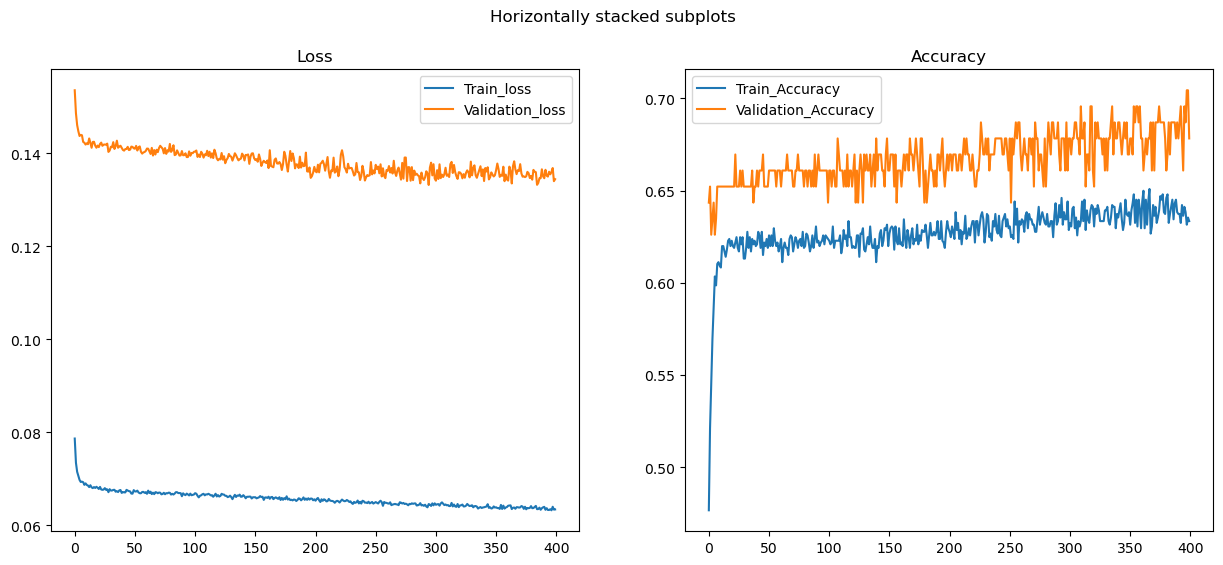

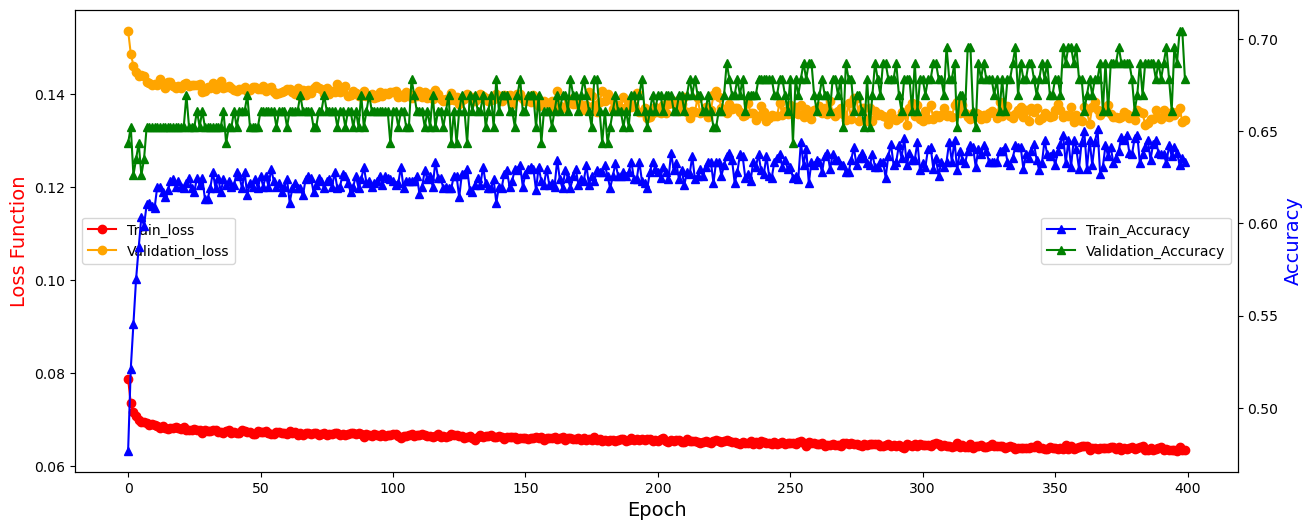

Current time: 78.849 minutes. Time expected till completion: 19.712 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 26.29it/s]


train loss:  0.06360249189620322
Val loss:  0.13716607197471287
train accuracy:  0.6470019342359767
Val accuracy:  0.6956521739130435
Current time: 79.051 minutes. Time expected till completion: 19.516 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06343119414217006
Val loss:  0.137657950753751
train accuracy:  0.6547388781431335
Val accuracy:  0.6782608695652174
Current time: 79.250 minutes. Time expected till completion: 19.320 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 27.49it/s]


train loss:  0.06360906621934828
Val loss:  0.13759913807329924
train accuracy:  0.6470019342359767
Val accuracy:  0.6608695652173913
Current time: 79.453 minutes. Time expected till completion: 19.124 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.06392781577672903
Val loss:  0.1382697623708974
train accuracy:  0.6450676982591876
Val accuracy:  0.6956521739130435
Current time: 79.656 minutes. Time expected till completion: 18.928 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 26.86it/s]


train loss:  0.0638748179090784
Val loss:  0.13849571528642074
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 79.855 minutes. Time expected till completion: 18.731 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06368049685221806
Val loss:  0.1355118487192237
train accuracy:  0.6470019342359767
Val accuracy:  0.6347826086956522
Current time: 80.054 minutes. Time expected till completion: 18.535 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06395601938033703
Val loss:  0.1382746934890747
train accuracy:  0.6392649903288201
Val accuracy:  0.6695652173913044
Current time: 80.259 minutes. Time expected till completion: 18.339 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06397638370497315
Val loss:  0.14007894992828368
train accuracy:  0.6411992263056093
Val accuracy:  0.6869565217391305
Current time: 80.459 minutes. Time expected till completion: 18.143 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 26.02it/s]


train loss:  0.06330512495751077
Val loss:  0.13548996033875838
train accuracy:  0.6411992263056093
Val accuracy:  0.7043478260869566
Current time: 80.656 minutes. Time expected till completion: 17.946 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 26.86it/s]


train loss:  0.06364083186339595
Val loss:  0.136758786180745
train accuracy:  0.6411992263056093
Val accuracy:  0.6782608695652174
Current time: 80.859 minutes. Time expected till completion: 17.750 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06354836499898531
Val loss:  0.13414641670558763
train accuracy:  0.6421663442940039
Val accuracy:  0.6782608695652174
Current time: 81.061 minutes. Time expected till completion: 17.553 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 26.86it/s]


train loss:  0.0636285299028142
Val loss:  0.13533693862997967
train accuracy:  0.6392649903288201
Val accuracy:  0.6956521739130435
Current time: 81.261 minutes. Time expected till completion: 17.357 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 27.00it/s]


train loss:  0.06380232569096858
Val loss:  0.13463849865871927
train accuracy:  0.6411992263056093
Val accuracy:  0.6869565217391305
Current time: 81.458 minutes. Time expected till completion: 17.160 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 28.48it/s]


train loss:  0.06316462839364545
Val loss:  0.1358349084854126
train accuracy:  0.6528046421663443
Val accuracy:  0.6434782608695652
Current time: 81.674 minutes. Time expected till completion: 16.966 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 27.35it/s]


train loss:  0.06321852217559888
Val loss:  0.13558501316153485
train accuracy:  0.6441005802707931
Val accuracy:  0.6956521739130435
Current time: 81.876 minutes. Time expected till completion: 16.770 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06352590494275785
Val loss:  0.13419847954874453
train accuracy:  0.6402321083172147
Val accuracy:  0.6782608695652174
Current time: 82.076 minutes. Time expected till completion: 16.573 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 26.57it/s]


train loss:  0.06347903355639031
Val loss:  0.13737056151680324
train accuracy:  0.6353965183752418
Val accuracy:  0.6782608695652174
Current time: 82.275 minutes. Time expected till completion: 16.376 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06263313856069538
Val loss:  0.1336777344993923
train accuracy:  0.6431334622823984
Val accuracy:  0.6956521739130435
Current time: 82.472 minutes. Time expected till completion: 16.179 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06367021528157321
Val loss:  0.1358405626338461
train accuracy:  0.6353965183752418
Val accuracy:  0.6869565217391305
Current time: 82.673 minutes. Time expected till completion: 15.982 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 27.45it/s]


train loss:  0.06351242708744809
Val loss:  0.13365942861722863
train accuracy:  0.6344294003868471
Val accuracy:  0.6782608695652174
Current time: 82.875 minutes. Time expected till completion: 15.786 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06322709867294798
Val loss:  0.13387198137200396
train accuracy:  0.6431334622823984
Val accuracy:  0.6956521739130435
Current time: 83.075 minutes. Time expected till completion: 15.589 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06373688826477966
Val loss:  0.13547147875246796
train accuracy:  0.6334622823984526
Val accuracy:  0.6869565217391305
Current time: 83.275 minutes. Time expected till completion: 15.392 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 27.30it/s]


train loss:  0.0637817428351832
Val loss:  0.1362486217332923
train accuracy:  0.6392649903288201
Val accuracy:  0.6782608695652174
Current time: 83.476 minutes. Time expected till completion: 15.195 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 27.30it/s]


train loss:  0.06376425279178287
Val loss:  0.13739712912103405
train accuracy:  0.6460348162475822
Val accuracy:  0.6869565217391305
Current time: 83.677 minutes. Time expected till completion: 14.999 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 27.05it/s]


train loss:  0.06316199414504105
Val loss:  0.1333375713099604
train accuracy:  0.6421663442940039
Val accuracy:  0.6695652173913044
Current time: 83.875 minutes. Time expected till completion: 14.801 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06371561130887074
Val loss:  0.13354178563408228
train accuracy:  0.6499032882011605
Val accuracy:  0.6869565217391305
Current time: 84.072 minutes. Time expected till completion: 14.604 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06331467576598752
Val loss:  0.13716911129329515
train accuracy:  0.6450676982591876
Val accuracy:  0.6869565217391305
Current time: 84.273 minutes. Time expected till completion: 14.407 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06365090274257401
Val loss:  0.13550767639408942
train accuracy:  0.6402321083172147
Val accuracy:  0.6782608695652174
Current time: 84.476 minutes. Time expected till completion: 14.211 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 27.35it/s]


train loss:  0.06355722447428529
Val loss:  0.1370308191879936
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 84.674 minutes. Time expected till completion: 14.014 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06340672268858269
Val loss:  0.13508060652276743
train accuracy:  0.6402321083172147
Val accuracy:  0.6869565217391305
Current time: 84.870 minutes. Time expected till completion: 13.816 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 26.43it/s]


train loss:  0.06333745909382804
Val loss:  0.13433867848437767
train accuracy:  0.6392649903288201
Val accuracy:  0.6869565217391305
Current time: 85.069 minutes. Time expected till completion: 13.619 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 28.17it/s]


train loss:  0.06352853896078335
Val loss:  0.13516570070515507
train accuracy:  0.6392649903288201
Val accuracy:  0.6869565217391305
Current time: 85.272 minutes. Time expected till completion: 13.422 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 26.39it/s]


train loss:  0.06318710268811976
Val loss:  0.13492261637812075
train accuracy:  0.6470019342359767
Val accuracy:  0.6869565217391305
Current time: 85.469 minutes. Time expected till completion: 13.225 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06348341841762255
Val loss:  0.138704820819523
train accuracy:  0.6431334622823984
Val accuracy:  0.6608695652173913
Current time: 85.669 minutes. Time expected till completion: 13.028 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 27.50it/s]


train loss:  0.06354466224777398
Val loss:  0.13568968461907427
train accuracy:  0.6421663442940039
Val accuracy:  0.6782608695652174
Current time: 85.867 minutes. Time expected till completion: 12.831 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 28.17it/s]


train loss:  0.06354467821536258
Val loss:  0.13923434122748998
train accuracy:  0.6411992263056093
Val accuracy:  0.6782608695652174
Current time: 86.071 minutes. Time expected till completion: 12.634 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 27.10it/s]


train loss:  0.06368292605853865
Val loss:  0.136487150710562
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 86.269 minutes. Time expected till completion: 12.437 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06265288043760009
Val loss:  0.13664537823718528
train accuracy:  0.6518375241779497
Val accuracy:  0.6956521739130435
Current time: 86.470 minutes. Time expected till completion: 12.240 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.06282385584233577
Val loss:  0.1380197944848434
train accuracy:  0.6450676982591876
Val accuracy:  0.6869565217391305
Current time: 86.676 minutes. Time expected till completion: 12.044 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06289051891064967
Val loss:  0.13517535043799359
train accuracy:  0.6402321083172147
Val accuracy:  0.6695652173913044
Current time: 86.877 minutes. Time expected till completion: 11.847 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 26.76it/s]


train loss:  0.06363033856367926
Val loss:  0.1347607830296392
train accuracy:  0.6450676982591876
Val accuracy:  0.6782608695652174
Current time: 87.073 minutes. Time expected till completion: 11.649 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 28.16it/s]


train loss:  0.06332336997386334
Val loss:  0.13586632842602936
train accuracy:  0.6460348162475822
Val accuracy:  0.6695652173913044
Current time: 87.272 minutes. Time expected till completion: 11.452 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 27.85it/s]


train loss:  0.06332050883562468
Val loss:  0.13578981420268182
train accuracy:  0.6479690522243714
Val accuracy:  0.6782608695652174
Current time: 87.470 minutes. Time expected till completion: 11.255 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 27.80it/s]


train loss:  0.06341619602255019
Val loss:  0.1360608054244
train accuracy:  0.6411992263056093
Val accuracy:  0.6695652173913044
Current time: 87.669 minutes. Time expected till completion: 11.057 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 26.62it/s]


train loss:  0.06291468986229001
Val loss:  0.13572212405826733
train accuracy:  0.6479690522243714
Val accuracy:  0.6869565217391305
Current time: 87.867 minutes. Time expected till completion: 10.860 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 27.30it/s]


train loss:  0.0631189786719169
Val loss:  0.1347834965457087
train accuracy:  0.6470019342359767
Val accuracy:  0.6695652173913044
Current time: 88.065 minutes. Time expected till completion: 10.663 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06355656830439023
Val loss:  0.1369169997132343
train accuracy:  0.6450676982591876
Val accuracy:  0.6869565217391305
Current time: 88.264 minutes. Time expected till completion: 10.465 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 28.76it/s]


train loss:  0.06311752239325061
Val loss:  0.13581224109815515
train accuracy:  0.6431334622823984
Val accuracy:  0.6782608695652174
Current time: 88.466 minutes. Time expected till completion: 10.268 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 26.20it/s]


train loss:  0.0634099762721034
Val loss:  0.13658171322034754
train accuracy:  0.6392649903288201
Val accuracy:  0.6869565217391305
Current time: 88.669 minutes. Time expected till completion: 10.072 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06307137283411893
Val loss:  0.13697393096011617
train accuracy:  0.6431334622823984
Val accuracy:  0.6521739130434783
Current time: 88.869 minutes. Time expected till completion: 9.874 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.06358417315224844
Val loss:  0.13565185018207715
train accuracy:  0.632495164410058
Val accuracy:  0.6869565217391305
Current time: 89.071 minutes. Time expected till completion: 9.677 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06342568440179068
Val loss:  0.13432802169219307
train accuracy:  0.648936170212766
Val accuracy:  0.6695652173913044
Current time: 89.278 minutes. Time expected till completion: 9.481 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 26.81it/s]


train loss:  0.06337637470123615
Val loss:  0.13639361391896787
train accuracy:  0.6499032882011605
Val accuracy:  0.6608695652173913
Current time: 89.473 minutes. Time expected till completion: 9.283 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.06290394315636597
Val loss:  0.13631422260533207
train accuracy:  0.6431334622823984
Val accuracy:  0.6782608695652174
Current time: 89.669 minutes. Time expected till completion: 9.085 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06403813221468455
Val loss:  0.13477639581846154
train accuracy:  0.6450676982591876
Val accuracy:  0.7043478260869566
Current time: 89.870 minutes. Time expected till completion: 8.888 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.06374342996101084
Val loss:  0.13604506306026293
train accuracy:  0.6411992263056093
Val accuracy:  0.6782608695652174
Current time: 90.069 minutes. Time expected till completion: 8.691 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 25.93it/s]


train loss:  0.06313975550219907
Val loss:  0.13613669094832048
train accuracy:  0.6479690522243714
Val accuracy:  0.6608695652173913
Current time: 90.269 minutes. Time expected till completion: 8.494 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.06322069284533163
Val loss:  0.13670411472735197
train accuracy:  0.6479690522243714
Val accuracy:  0.6695652173913044
Current time: 90.467 minutes. Time expected till completion: 8.296 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 28.81it/s]


train loss:  0.06284105921852289
Val loss:  0.13450413994167162
train accuracy:  0.6508704061895552
Val accuracy:  0.6956521739130435
Current time: 90.668 minutes. Time expected till completion: 8.099 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06277690796141928
Val loss:  0.1340755659600963
train accuracy:  0.6421663442940039
Val accuracy:  0.6782608695652174
Current time: 90.869 minutes. Time expected till completion: 7.902 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 26.48it/s]


train loss:  0.06351804819743453
Val loss:  0.13560069540272587
train accuracy:  0.6450676982591876
Val accuracy:  0.6782608695652174
Current time: 91.066 minutes. Time expected till completion: 7.704 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06327878898532063
Val loss:  0.13702725742174232
train accuracy:  0.648936170212766
Val accuracy:  0.6956521739130435
Current time: 91.266 minutes. Time expected till completion: 7.507 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 27.70it/s]


train loss:  0.06287449869242581
Val loss:  0.13649709743002186
train accuracy:  0.6460348162475822
Val accuracy:  0.6869565217391305
Current time: 91.465 minutes. Time expected till completion: 7.309 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.0627942172886094
Val loss:  0.13648741970891537
train accuracy:  0.6470019342359767
Val accuracy:  0.6782608695652174
Current time: 91.666 minutes. Time expected till completion: 7.112 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 26.76it/s]


train loss:  0.06341071850557162
Val loss:  0.13796093049256697
train accuracy:  0.6479690522243714
Val accuracy:  0.7043478260869566
Current time: 91.862 minutes. Time expected till completion: 6.914 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 27.45it/s]


train loss:  0.06305843095945436
Val loss:  0.13487007514290186
train accuracy:  0.6421663442940039
Val accuracy:  0.6869565217391305
Current time: 92.059 minutes. Time expected till completion: 6.717 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 28.32it/s]


train loss:  0.0631363485837121
Val loss:  0.13718266746272212
train accuracy:  0.6402321083172147
Val accuracy:  0.6695652173913044
Current time: 92.263 minutes. Time expected till completion: 6.520 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06317360719352441
Val loss:  0.13570826831071273
train accuracy:  0.6441005802707931
Val accuracy:  0.6782608695652174
Current time: 92.461 minutes. Time expected till completion: 6.322 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 25.93it/s]


train loss:  0.06279568048464261
Val loss:  0.1352645946585614
train accuracy:  0.6499032882011605
Val accuracy:  0.6782608695652174
Current time: 92.658 minutes. Time expected till completion: 6.125 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


train loss:  0.06343402501692855
Val loss:  0.13622902735419895
train accuracy:  0.648936170212766
Val accuracy:  0.6782608695652174
Current time: 92.858 minutes. Time expected till completion: 5.927 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06285277251118157
Val loss:  0.13689923752909122
train accuracy:  0.6595744680851063
Val accuracy:  0.6608695652173913
Current time: 93.059 minutes. Time expected till completion: 5.730 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 27.96it/s]


train loss:  0.06260624153240506
Val loss:  0.13615093697672304
train accuracy:  0.6653771760154739
Val accuracy:  0.6608695652173913
Current time: 93.262 minutes. Time expected till completion: 5.533 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 26.76it/s]


train loss:  0.06290285580393425
Val loss:  0.13626574796179067
train accuracy:  0.6595744680851063
Val accuracy:  0.6956521739130435
Current time: 93.459 minutes. Time expected till completion: 5.335 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 27.90it/s]


train loss:  0.06329367383305755
Val loss:  0.13893889603407486
train accuracy:  0.6537717601547389
Val accuracy:  0.7043478260869566
Current time: 93.656 minutes. Time expected till completion: 5.137 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 27.65it/s]


train loss:  0.06302265445314477
Val loss:  0.13675800717395284
train accuracy:  0.6644100580270793
Val accuracy:  0.6608695652173913
Current time: 93.855 minutes. Time expected till completion: 4.940 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 27.85it/s]


train loss:  0.06277379168763152
Val loss:  0.13779808490172676
train accuracy:  0.6508704061895552
Val accuracy:  0.6869565217391305
Current time: 94.055 minutes. Time expected till completion: 4.742 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 26.81it/s]


train loss:  0.06333911349741125
Val loss:  0.1379531487174656
train accuracy:  0.6411992263056093
Val accuracy:  0.6956521739130435
Current time: 94.254 minutes. Time expected till completion: 4.545 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 29.03it/s]


train loss:  0.06304443931671821
Val loss:  0.13560321227363917
train accuracy:  0.6537717601547389
Val accuracy:  0.6869565217391305
Current time: 94.456 minutes. Time expected till completion: 4.347 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06347826359580978
Val loss:  0.13592826853627743
train accuracy:  0.6576402321083172
Val accuracy:  0.6608695652173913
Current time: 94.654 minutes. Time expected till completion: 4.150 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06243065224394807
Val loss:  0.13498371062071426
train accuracy:  0.6450676982591876
Val accuracy:  0.6956521739130435
Current time: 94.853 minutes. Time expected till completion: 3.952 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 26.86it/s]


train loss:  0.06300874120723349
Val loss:  0.13709633091221685
train accuracy:  0.6392649903288201
Val accuracy:  0.6521739130434783
Current time: 95.050 minutes. Time expected till completion: 3.755 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 28.49it/s]


train loss:  0.06291566515337799
Val loss:  0.1360883469166963
train accuracy:  0.6518375241779497
Val accuracy:  0.6608695652173913
Current time: 95.252 minutes. Time expected till completion: 3.557 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 28.65it/s]


train loss:  0.06339780983426815
Val loss:  0.13410840863766876
train accuracy:  0.6421663442940039
Val accuracy:  0.6782608695652174
Current time: 95.450 minutes. Time expected till completion: 3.360 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


train loss:  0.06347640242060103
Val loss:  0.13460220357646113
train accuracy:  0.6460348162475822
Val accuracy:  0.6782608695652174
Current time: 95.648 minutes. Time expected till completion: 3.162 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 26.34it/s]


train loss:  0.06273686851246905
Val loss:  0.13420833815699038
train accuracy:  0.6470019342359767
Val accuracy:  0.6608695652173913
Current time: 95.843 minutes. Time expected till completion: 2.964 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 27.25it/s]


train loss:  0.06288391368993246
Val loss:  0.1358244325803674
train accuracy:  0.6499032882011605
Val accuracy:  0.6695652173913044
Current time: 96.050 minutes. Time expected till completion: 2.767 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 27.15it/s]


train loss:  0.06315245769010061
Val loss:  0.13363464707913605
train accuracy:  0.6508704061895552
Val accuracy:  0.6869565217391305
Current time: 96.251 minutes. Time expected till completion: 2.569 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.06276762231867364
Val loss:  0.1352532739224641
train accuracy:  0.6499032882011605
Val accuracy:  0.6869565217391305
Current time: 96.452 minutes. Time expected till completion: 2.372 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 28.11it/s]


train loss:  0.06304177134595018
Val loss:  0.13527017831802368
train accuracy:  0.6537717601547389
Val accuracy:  0.6956521739130435
Current time: 96.650 minutes. Time expected till completion: 2.174 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 28.01it/s]


train loss:  0.0631544174954324
Val loss:  0.13477715616640837
train accuracy:  0.6421663442940039
Val accuracy:  0.6956521739130435
Current time: 96.851 minutes. Time expected till completion: 1.977 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 28.43it/s]


train loss:  0.06360751730561026
Val loss:  0.13588699620702993
train accuracy:  0.648936170212766
Val accuracy:  0.6956521739130435
Current time: 97.049 minutes. Time expected till completion: 1.779 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 28.27it/s]


train loss:  0.0629141814934677
Val loss:  0.1347412347793579
train accuracy:  0.6518375241779497
Val accuracy:  0.6869565217391305
Current time: 97.248 minutes. Time expected till completion: 1.581 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 27.40it/s]


train loss:  0.06295116778960311
Val loss:  0.13649363932402236
train accuracy:  0.6566731141199227
Val accuracy:  0.6782608695652174
Current time: 97.442 minutes. Time expected till completion: 1.384 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 28.70it/s]


train loss:  0.06286908752452475
Val loss:  0.13574086945989858
train accuracy:  0.6537717601547389
Val accuracy:  0.6956521739130435
Current time: 97.639 minutes. Time expected till completion: 1.186 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


train loss:  0.06267490902306724
Val loss:  0.13790221732595692
train accuracy:  0.6518375241779497
Val accuracy:  0.6608695652173913
Current time: 97.838 minutes. Time expected till completion: 0.988 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 26.81it/s]


train loss:  0.06263440812810016
Val loss:  0.1383984368780385
train accuracy:  0.6508704061895552
Val accuracy:  0.6521739130434783
Current time: 98.034 minutes. Time expected till completion: 0.791 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 28.43it/s]


train loss:  0.06311808713861314
Val loss:  0.13606528302897578
train accuracy:  0.6450676982591876
Val accuracy:  0.6608695652173913
Current time: 98.231 minutes. Time expected till completion: 0.593 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 27.39it/s]


train loss:  0.06293916108529848
Val loss:  0.13882850149403447
train accuracy:  0.6518375241779497
Val accuracy:  0.6695652173913044
Current time: 98.427 minutes. Time expected till completion: 0.395 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 27.55it/s]


train loss:  0.06252623463276508
Val loss:  0.135845510855965
train accuracy:  0.6537717601547389
Val accuracy:  0.6869565217391305
Current time: 98.630 minutes. Time expected till completion: 0.198 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


train loss:  0.0625393071880193
Val loss:  0.1369131591009057
train accuracy:  0.6547388781431335
Val accuracy:  0.6956521739130435
Saving model checkpoint


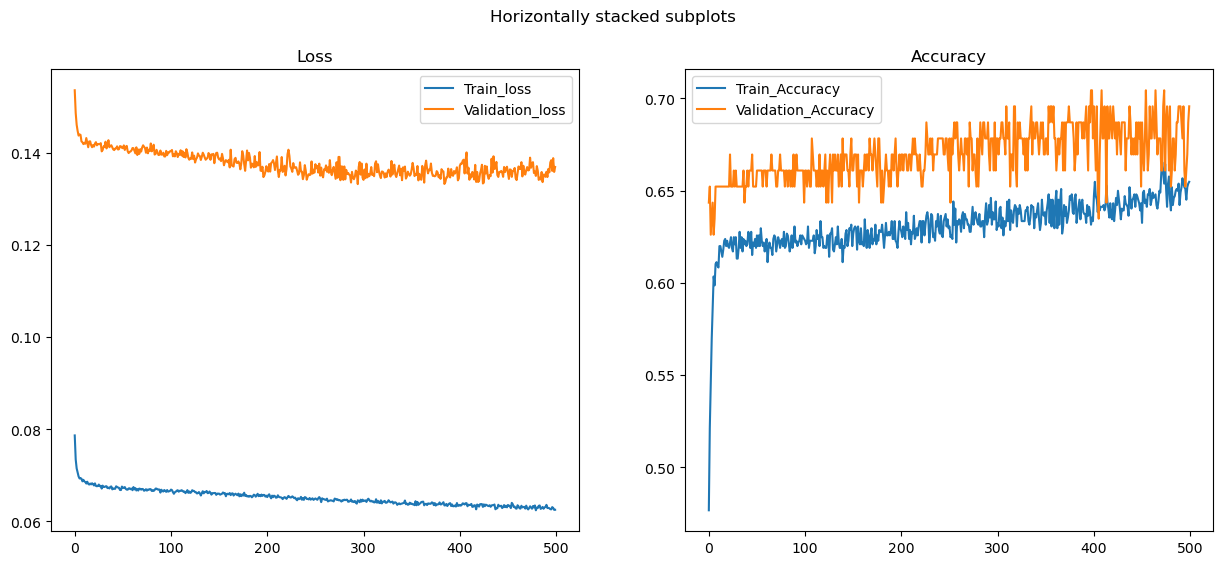

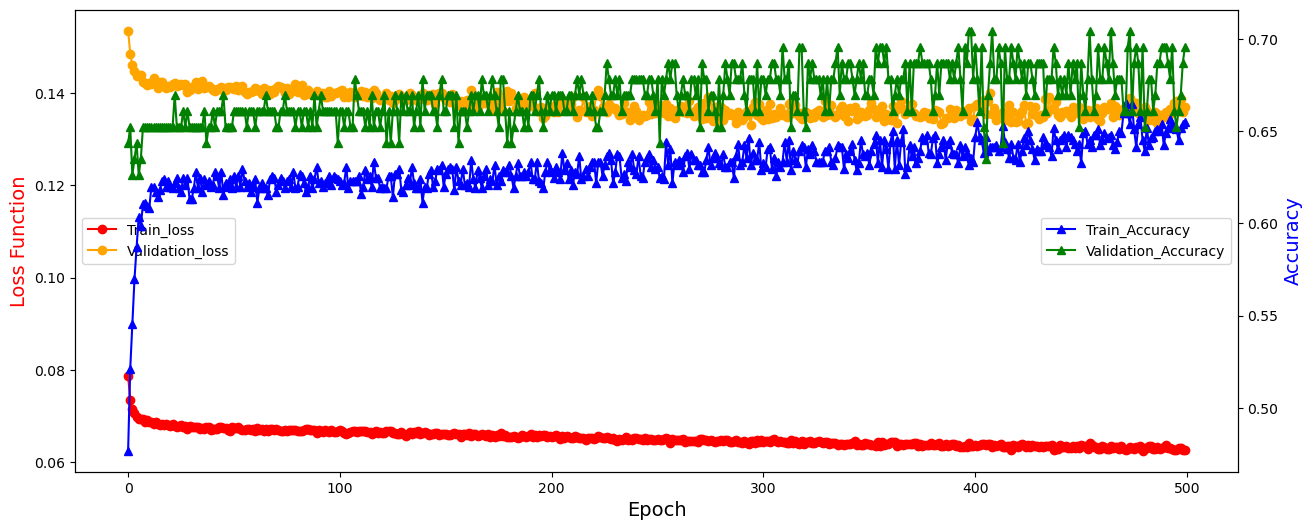

Current time: 98.851 minutes. Time expected till completion: 0.000 minutes
Finished training in: 98.851 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

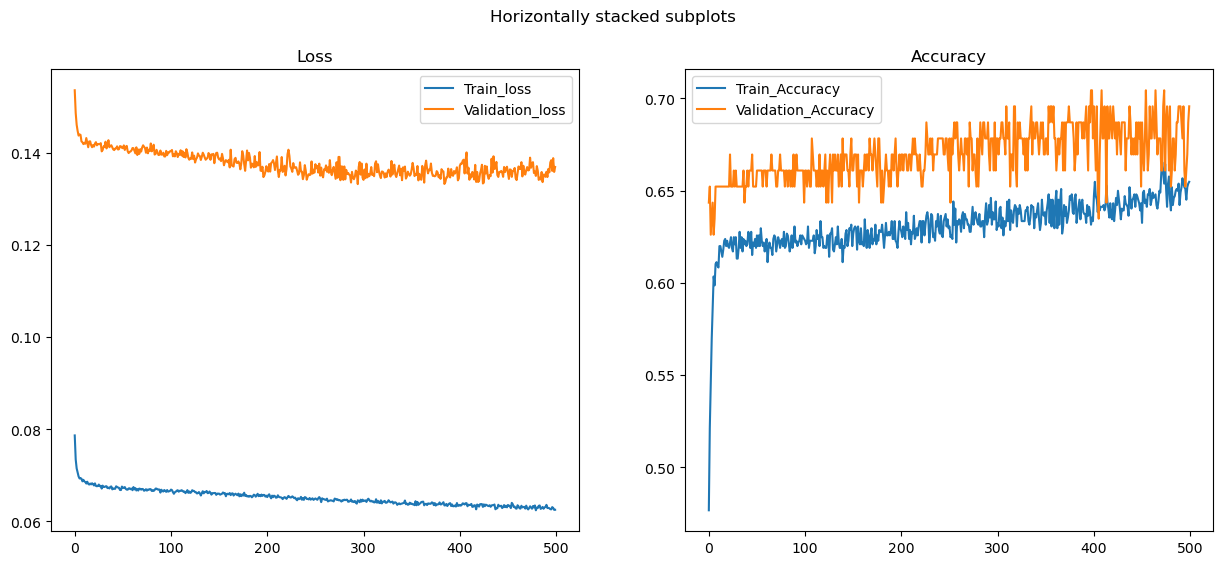

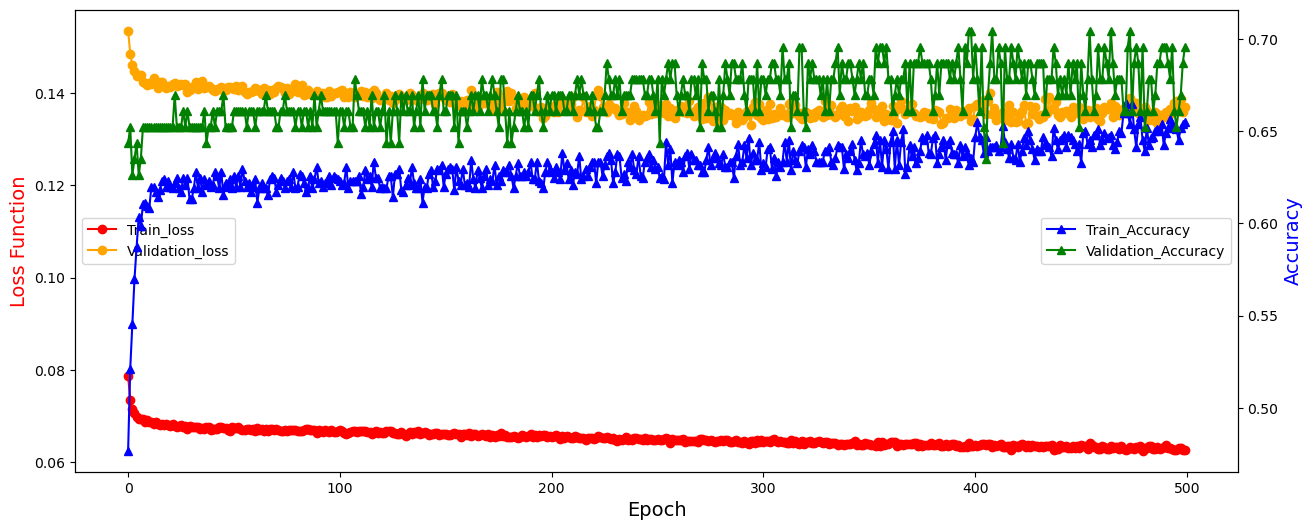

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 64.60348162475822%
Accuracy of the network on the 115 Validation instances: 69.56521739130434%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="03_8Conv_4Res_15FChannels_4Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points